<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:10px 5px'> 
Master Thesis Yannik Haller - LDA
</h1>
</div>

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
1. Load required packages and the data
</h2>
</div>

In [1]:
# Import required baseline packages
import re
import os
import glob
import time
import sys
import pandas as pd
import numpy as np
from pprint import pprint
from operator import itemgetter 

# Change pandas' setting to print out long strings
pd.options.display.max_colwidth = 200

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Spacy (for lemmatization)
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
# Set global parameters for plotting
import matplotlib.pylab as pylab
params = {'legend.fontsize': 10,
          'figure.figsize': (8, 6),
          'axes.labelsize': 14,
          'axes.titlesize': 16,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10}
pylab.rcParams.update(params)

# Regression and smoothing tools
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold

# Enable logging for gensim (optional)
import logging
logging.basicConfig(format = '%(asctime)s : %(levelname)s : %(message)s', level = logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
warnings.filterwarnings("ignore", category = FutureWarning)

C:\Users\Hallk\AppData\Roaming\Python\Python37\site-packages\ipykernel\pylab\config.py:70: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [2]:
# Set the appropriate working directory
os.chdir('D:\\Dropbox\\MA_data')

In [3]:
# Define a function to read in the fully preprocessed data (unigrams)
def read_preprocessed(language, tokenize = True):
    # Raise an error if an inadmissible language is chosen
    allowed_languages = ['de', 'en', 'fr', 'it']
    if language not in allowed_languages:
        raise ValueError("Invalid language. Expected one of: %s" % allowed_languages)
    
    # Set the appropriate working directory
    os.chdir('D:\\Dropbox\\MA_data')

    # Define the name of the file to load
    filename = "Preprocessed/"+language+"_preprocessed.csv"

    # Read in the dataframe containing the text data
    tx_pp = pd.read_csv(filename, index_col = 0, dtype = {'tx': object})

    # Get the articles' index together with an enumeration to identify their position in the list of precleaned articles
    idx = tx_pp.index
    idx = pd.DataFrame(idx, columns = [language+'_idx'])

    # Reduce the dataframe to a list containing the text data
    tx_pp = tx_pp.tx.to_list()

    # Tokenize the data again if tokenize = True (RAM-saving)
    if tokenize:
        tx_pp = retokenize(tx_pp)

    # Return the preprocessed data
    return tx_pp, idx

# Define a function to retokenize the preprocessed text data (RAM-saving)
def retokenize(article_list):
    for i in range(len(article_list)):
        temp_tx = str(article_list[i]).split()
        article_list[i] = temp_tx
    return article_list

In [4]:
# Define a function to read in the preprocessed fulltext data
def read_preprocessed_fulltext(language):
    # Raise an error if an inadmissible language is chosen
    allowed_languages = ['de', 'en', 'fr', 'it']
    if language not in allowed_languages:
        raise ValueError("Invalid language. Expected one of: %s" % allowed_languages)
    
    # Set the appropriate working directory
    os.chdir('D:\\Dropbox\\MA_data')

    # Define the name of the file to load
    filename = "Preprocessed/Fulltext/"+language+"_fulltext.csv"

    # Read in the data
    tx_ft = pd.read_csv(filename, index_col = 0, dtype = {'tx': object})

    # Get the articles' index together with an enumeration to identify their position in the list of precleaned articles
    idx = tx_ft.index
    idx = pd.DataFrame(idx, columns = [language+'_idx'])

    # Extract the text data as a list of articles
    tx_ft = tx_ft.tx.to_list()

    # Return the preprocessed data
    return tx_ft, idx

In [5]:
# Read in the topic assignments of the general LDA models for each article
articles_topics = pd.read_csv("LDA/Topic_Assignment/topic_assignment_general.csv", index_col = 0)
# Take a look at the dataframe
articles_topics

,Topic_ID_1,Affiliation_Prob_1,Topic_ID_2,Affiliation_Prob_2,Topic_1,Topic_2
0,1,0.329300,7.0,0.292654,politics_international,economy_international
1,7,0.462487,11.0,0.269677,economy_international,economy_national
2,7,0.325522,11.0,0.232608,economy_international,economy_national
3,7,0.473720,11.0,0.470850,economy_international,economy_national
4,7,0.598861,11.0,0.281546,economy_international,economy_national
...,...,...,...,...,...,...
2441178,17,0.466716,2.0,0.251594,economy_national,inconsequential
2441179,12,0.315961,21.0,0.274781,inconsequential,economy_national
2441180,26,0.377586,29.0,0.296713,sports,law_order
2441181,23,0.433544,13.0,0.272896,tragedies_crimes,law_order


In [6]:
# Get the indexes of the articles that are about Covid (i.e. either articles with Topic_1 = COVID or Topic_2 = COVID and Affiliation_Prob_2 >= 0.25)
Covid_idx = articles_topics.loc[np.logical_or(articles_topics['Topic_1'] == 'COVID', 
                                              np.logical_and(articles_topics['Topic_2'] == 'COVID', 
                                                             articles_topics['Affiliation_Prob_2'] >= 0.25))].index
# Remove the unnecessary variable to save RAM
del articles_topics

In [7]:
# Read in the preprocessed data
fr_tx, fr_idx = read_preprocessed('fr')

# Take a look at the size of the precleaned data
sys.getsizeof(fr_tx)

3849360

In [8]:
## Reduce the data to the Covid articles
# Retrieve the location of the Covid article in the preprocessed data
location = fr_idx[fr_idx.fr_idx.isin(Covid_idx)].index.tolist()
# Get the Text Data of the Covid articles
fr_tx = itemgetter(*location)(fr_tx)
# Reduce the dataframe containing the index to the Covid articles
fr_idx = fr_idx.iloc[location]
fr_idx.set_index(np.arange(fr_idx.shape[0]), inplace = True)
# Take a look at how many articles remain
len(fr_tx)

26003

In [9]:
# Take a look at the preprocessed data of the Covid articles
fr_tx[0][:6]

['christian', 'affolter', 'matteo', 'ianni', 'sophie', 'marennedix']

In [10]:
# Take a look at the dataframe containing the according index
fr_idx.tail(3)

,fr_idx
26000,2436462
26001,2436478
26002,2436479


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 2. Create the Dictionary and Corpus needed for Topic Modeling</h2>
</div>

The two main inputs to the LDA topic model are the dictionary and the corpus. So let's create them subsequently

In [11]:
# Create Dictionary
dictionary = corpora.Dictionary(fr_tx)

# Filter the dictionary such that only tokens that are contained in at least 1%, but at most 80% of the articles are considered, while only keeping the 100K most common tokens
dictionary.filter_extremes(no_below = int(len(fr_tx)/100), no_above = 0.8, keep_n = 100000)

# Take a look at the resulting size of the dictionary (i.e. how many words are kept)
len(dictionary)

2383

In [12]:
# Check whether the most common language specific corona phrases are still contained
for i in range(len(dictionary)):
    if dictionary[i] == 'coronavirus':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break
for i in range(len(dictionary)):
    if dictionary[i] == 'corona':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break  
for i in range(len(dictionary)):
    if dictionary[i] == 'covid':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break
for i in range(len(dictionary)):
    if dictionary[i] == 'virus':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break
for i in range(len(dictionary)):
    if dictionary[i] == 'pandémie':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break

At pos. 303 we find the word coronavirus
At pos. 36 we find the word covid
At pos. 248 we find the word virus
At pos. 119 we find the word pandémie


In [13]:
# Create Dictionary
dictionary = corpora.Dictionary(fr_tx)

# Filter the dictionary such that only tokens that are contained in at least 1%, but at most 34% of the articles are considered, while only keeping the 100K most common tokens
dictionary.filter_extremes(no_below = int(len(fr_tx)/100), no_above = 0.34, keep_n = 100000)

# Take a look at the resulting size of the dictionary (i.e. how many words are kept)
len(dictionary)

2362

In [14]:
# Check whether the most common language specific corona phrases are still contained
for i in range(len(dictionary)):
    if dictionary[i] == 'coronavirus':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break
for i in range(len(dictionary)):
    if dictionary[i] == 'corona':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break  
for i in range(len(dictionary)):
    if dictionary[i] == 'covid':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break
for i in range(len(dictionary)):
    if dictionary[i] == 'virus':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break
for i in range(len(dictionary)):
    if dictionary[i] == 'pandémie':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break

In [15]:
# Create corpus and term document frequency
corpus = [dictionary.doc2bow(article) for article in fr_tx]

# View the first element of the corpus as an example
print(corpus[:1])

[[(0, 1), (1, 3), (2, 1), (3, 6), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 3), (22, 1), (23, 4), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 3), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 1), (46, 4), (47, 2), (48, 1), (49, 1), (50, 2), (51, 1), (52, 1), (53, 3), (54, 4), (55, 1), (56, 1), (57, 1), (58, 2), (59, 1), (60, 1), (61, 2), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 2), (71, 1), (72, 1), (73, 1), (74, 1), (75, 2), (76, 1), (77, 1), (78, 1), (79, 3), (80, 1), (81, 1), (82, 3), (83, 3), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 2), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 2), (98, 1), (99, 1), (100, 1), (101, 2), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)

In [16]:
# Remove unnecessary variables to save RAM
del fr_tx

Note: 

- Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).
- In order to observe the word that corresponds to a given id, pass the id as a key to the dictionary.

In [17]:
# Get the phrase corresponding to id 0
dictionary[0]

'abri'

In [18]:
# Get a human readable format of the corpus (term-frequency)
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('abri', 1),
  ('absence', 3),
  ('actif', 1),
  ('activité', 6),
  ('administratif', 1),
  ('affecter', 1),
  ('aide', 1),
  ('aimer', 1),
  ('anticiper', 1),
  ('approche', 2),
  ('appuyer', 1),
  ('arriver', 1),
  ('autant', 1),
  ('autorité', 1),
  ('avance', 1),
  ('bon', 1),
  ('cantonal', 2),
  ('cause', 1),
  ('chambre', 1),
  ('choix', 1),
  ('christian', 1),
  ('claude', 3),
  ('client', 1),
  ('collaborateur', 4),
  ('commerce', 1),
  ('comprendre', 1),
  ('compter', 1),
  ('compétence', 1),
  ('considérer', 1),
  ('consigne', 1),
  ('conséquence', 1),
  ('contact', 1),
  ('contamination', 1),
  ('contraire', 1),
  ('court', 1),
  ('côté', 2),
  ('danger', 1),
  ('demander', 1),
  ('difficulté', 1),
  ('directeur', 3),
  ('disposer', 1),
  ('dispositif', 2),
  ('distance', 1),
  ('distanciation', 1),
  ('dizaine', 1),
  ('dossier', 1),
  ('durée', 4),
  ('déjà', 2),
  ('dépasser', 1),
  ('dérouler', 1),
  ('détaille', 2),
  ('effectuer', 1),
  ('emploi', 1),
  ('employé', 

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 3. Building the Topic Model</h2>
</div>

Now we have everything required to train the LDA model. In addition to the corpus and dictionary, we need to provide the number of topics K and several further hyperparameters as well. To choose the hyperparameters other than the number of topics and the number of passes, we rely on the suggestions given either by Hoffman, Bach & Blei (2010) (for workers, chunksize, offset, decay and eval_every) or by the default settings of the model (for alpha, eta and minimum_probability). The parameter "passes" is chosen such that the model can be trained reasonably and in feasible amount of time. The random state to generate the initial model parameters is set to 7.

Parameters overview:

- workers: number of cpu cores to use for computation (optimal performance if it is set to # of REAL cores - 1)
- num_topics: number of topics to distinguish
- passes: total number of training passes (comparable to epochs in ANN)
- alpha: a 1D array of length equal to the number of expected topics that expresses our a-priori belief on each topic probability (default = 'symmetric' $\rightarrow$ corresponds to 1/num_topics)
- eta: a-priori belief on word probability (either overall or topic specific) (default = None $\rightarrow$ corresponds 1/num_words for all topics)
- minimum_probability: topics with a probability lower than this threshold will be filtered out
- offset: corresponds to $\tau_0$ in Hoffman, Bach & Blei (2010) (chosen according to the identified "Best parameter settings for Wikipedia corpus" in said paper)
- decay: corresponds to $\kappa$ in Hoffman, Bach & Blei (2010). It should be chosen such that $\kappa \in (0.5,1]$ to guarantee convergence. (chosen according to the identified "Best parameter settings for Wikipedia corpus" in said paper)
- eval_every: The performance of the model (measured using the log-perplexity) is estimated every eval_every updates. It corresponds to the batchsize in Hoffman, Bach & Blei (2010) (approximately chosen according to the identified "Best parameter settings for Wikipedia corpus" in said paper)
- chunksize: number of documents to be used in each training chunk (corresponds to batchsize/workers)

In [19]:
# Build LDA model paralellized
t = time.time()
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus              = corpus,
                                                    id2word             = dictionary,
                                                    workers             = 5,
                                                    num_topics          = 10,
                                                    chunksize           = int(4095/5), # Corresponds to batch_size/workers
                                                    passes              = 12, 
                                                    alpha               = 'symmetric',
                                                    eta                 = None,
                                                    minimum_probability = 0.01,
                                                    offset              = 64,
                                                    decay               = 0.5,
                                                    eval_every          = 4095,
                                                    random_state        = 7,
                                                    per_word_topics     = True)
print("Processing time to build the LDA model paralellized: ", str((time.time() - t)/60), "minutes")

Processing time to build the LDA model paralellized:  1.4703228314717611 minutes


In [20]:
# Save the model to harddisk
lda_model.save("LDA/Covid/fr_lda_model_"+str(lda_model.num_topics)+"_topics")

In [21]:
# Delete unnecessary variables (stored as modelname.id2word)
del dictionary

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 4. View the topics in the LDA model</h2>
</div>

The above LDA model is built with a predetermined number of distingushied topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic. Thus, we can visualize the keywords for each topic and the weightage (importance) of each keyword as follows.

In [5]:
# Load a pretrained model from disk (adjust the digit appropriately!!!)
lda_model = gensim.models.ldamodel.LdaModel.load("LDA/Covid/fr_lda_model_10_topics")         # adjust the digit appropriately

In [6]:
# Print the 10 most important keywords for each topic
pprint(lda_model.print_topics())

[(0,
  '0.014*"épidémie" + 0.012*"chine" + 0.009*"ville" + 0.008*"autorité" + '
  '0.008*"président" + 0.008*"état" + 0.007*"chinois" + 0.007*"gouvernement" + '
  '0.007*"wuhan" + 0.007*"mort"'),
 (1,
  '0.011*"crise" + 0.007*"faire" + 0.006*"entreprise" + 0.006*"confinement" + '
  '0.006*"mois" + 0.005*"année" + 0.005*"grand" + 0.005*"aide" + '
  '0.005*"social" + 0.005*"temps"'),
 (2,
  '0.015*"confinement" + 0.013*"gouvernement" + 0.012*"ministre" + '
  '0.011*"royaume" + 0.010*"uni" + 0.010*"britannique" + 0.009*"région" + '
  '0.008*"vague" + 0.007*"france" + 0.007*"europe"'),
 (3,
  '0.017*"vaccin" + 0.012*"vaccination" + 0.010*"maladie" + 0.009*"vacciner" + '
  '0.009*"oms" + 0.008*"épidémie" + 0.008*"population" + 0.007*"risque" + '
  '0.007*"dose" + 0.006*"grippe"'),
 (4,
  '0.039*"masque" + 0.013*"port" + 0.010*"obligatoire" + 0.009*"distance" + '
  '0.008*"école" + 0.008*"respecter" + 0.008*"porter" + 0.008*"fermer" + '
  '0.007*"lieu" + 0.007*"établissement"'),
 (5,
  '0.02

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 5. Compute Model Perplexity and Coherence Score</h2>
</div>

Model perplexity and [topic coherence](https://rare-technologies.com/what-is-topic-coherence/) (as explained in Röder, Both & Hinneburg (2015)) provide a convenient measure to judge how good a given topic model is. (Experience has shown that topic coherence score, in particular, has been more helpful)

In [7]:
# Load a pretrained model from disk (adjust the digit appropriately!!!)
lda_model = gensim.models.ldamodel.LdaModel.load("LDA/Covid/fr_lda_model_10_topics")         # adjust the digit appropriately

In [8]:
# Read in the preprocessed data of the Covid articles
articles_topics = pd.read_csv("LDA/Topic_Assignment/topic_assignment_general.csv", index_col = 0)
Covid_idx = articles_topics.loc[np.logical_or(articles_topics['Topic_1'] == 'COVID', 
                                              np.logical_and(articles_topics['Topic_2'] == 'COVID', 
                                                             articles_topics['Affiliation_Prob_2'] >= 0.25))].index
del articles_topics
fr_tx, fr_idx = read_preprocessed('fr')
location = fr_idx[fr_idx.fr_idx.isin(Covid_idx)].index.tolist()
fr_tx = itemgetter(*location)(fr_tx)
fr_idx = fr_idx.iloc[location]
fr_idx.set_index(np.arange(fr_idx.shape[0]), inplace = True)

In [9]:
# Create the corpus again
corpus = [lda_model.id2word.doc2bow(article) for article in fr_tx]

In [10]:
# Compute Perplexity
print('Perplexity of the LDA model with', str(lda_model.num_topics), 'topics:', lda_model.log_perplexity(corpus))  # A measure of how good the model is. The lower the better.

Perplexity of the LDA model with 10 topics: -6.997749480437845


In [11]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model = lda_model, texts = fr_tx, dictionary = lda_model.id2word, coherence = 'c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score of the LDA model with', str(lda_model.num_topics), 'topics:', coherence_lda)

Coherence Score of the LDA model with 10 topics: 0.47942022524144556


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 6. Visualize the topics-keywords</h2>
</div>

Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. We do so by means of the pyLDAvis package’s interactive chart which is designed to work well with jupyter notebooks.

In [12]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.093486 -0.096264       1        1  12.823080
9     -0.183490 -0.035553       2        1  12.652520
0      0.090614 -0.001817       3        1  11.567488
4      0.027282  0.046614       4        1  11.033714
2      0.079250  0.064089       5        1  10.432874
6      0.109902  0.019457       6        1   9.856549
5     -0.035137 -0.113918       7        1   9.203105
8     -0.129474  0.158206       8        1   8.901033
1      0.105779 -0.080405       9        1   8.101263
3      0.028759  0.039592      10        1   5.428374, topic_info=            Term          Freq         Total Category  logprob  loglift
98        masque  23686.000000  23686.000000  Default  30.0000  30.0000
17           cas  52514.000000  52514.000000  Default  29.0000  29.0000
370       canton  20859.000000  20859.000000  Default  28.0000  28.0000
149  quarantaine  13361.000000  13361.000000  Default  27.0000  27.0000
395      fédéral  18562.000000  18562.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
133      prendre   1248.145425  18778.550764  Topic10  -5.3194   0.2025
50          déjà   1156.281416  12848.627097  Topic10  -5.3958   0.5055
32       contact   1130.992667   8444.153143  Topic10  -5.4179   0.9032
818     vendredi   1140.369608  10935.537730  Topic10  -5.4097   0.6529
295     annoncer   1121.913704  19503.349566  Topic10  -5.4260   0.0580

[646 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1797      1  0.062903    accueil
1797      2  0.016281    accueil
1797      3  0.034782    accueil
1797      4  0.004440    accueil
1797      5  0.661593    accueil
...     ...       ...        ...
439       6  0.006429  événement
439       7  0.047339  événement
439       8  0.005552  événement
439       9  0.608975  événement
439      10  0.032728  événement

[3787 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 10, 1, 5, 3, 7, 6, 9, 2, 4])

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 7. Find the optimal number of topics (K) for the LDA model </h2>
</div>

To find the optimal number of topics K for our LDA model, we set up a function to train multiple LDA models for differnet values of K, while keeping track of the processing time and the according coherence scores. A commonly applied method to identify the optimal K then is to choose the model according to one of the following two criterions:

1. Choose K such that the coherence score is maximized (can sometimes provide too granular sub-topics)

2. Choose the model which indicates the end of a steep growth in terms of the coherence score (usually offers meaningful and interpretable topics)

However, to evaluate the quality of the topic models later on we then additionally consider similarities in the top ranked keywords among the resulting topics. Observing that the exact same keyword appears at a high ranking in multiple topics would be an indicator that the chosen K is probably too large. The similarity among the resulting topics can then be assessed by means of the so called Jaccardian similarity, whose concept is introduced in greater detail in Section 7.3.

In [5]:
# Read in the preprocessed data of the Covid articles
articles_topics = pd.read_csv("LDA/Topic_Assignment/topic_assignment_general.csv", index_col = 0)
Covid_idx = articles_topics.loc[np.logical_or(articles_topics['Topic_1'] == 'COVID', 
                                              np.logical_and(articles_topics['Topic_2'] == 'COVID', 
                                                             articles_topics['Affiliation_Prob_2'] >= 0.25))].index
del articles_topics
fr_tx, fr_idx = read_preprocessed('fr')
location = fr_idx[fr_idx.fr_idx.isin(Covid_idx)].index.tolist()
fr_tx = itemgetter(*location)(fr_tx)
fr_idx = fr_idx.iloc[location]
fr_idx.set_index(np.arange(fr_idx.shape[0]), inplace = True)

In [6]:
# Create Dictionary
dictionary = corpora.Dictionary(fr_tx)

# Filter the dictionary such that only tokens that are contained in at least 1%, but at most 34% of the articles are considered, while only keeping the 100K most common tokens
dictionary.filter_extremes(no_below = int(len(fr_tx)/100), no_above = 0.34, keep_n = 100000)

# Take a look at the resulting size of the dictionary (i.e. how many words are kept)
len(dictionary)

2362

In [7]:
# Create corpus and term document frequency
corpus = [dictionary.doc2bow(article) for article in fr_tx]

# View the first element of the corpus as an example
print(corpus[:1])

[[(0, 1), (1, 3), (2, 1), (3, 6), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 3), (22, 1), (23, 4), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 3), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 1), (46, 4), (47, 2), (48, 1), (49, 1), (50, 2), (51, 1), (52, 1), (53, 3), (54, 4), (55, 1), (56, 1), (57, 1), (58, 2), (59, 1), (60, 1), (61, 2), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 2), (71, 1), (72, 1), (73, 1), (74, 1), (75, 2), (76, 1), (77, 1), (78, 1), (79, 3), (80, 1), (81, 1), (82, 3), (83, 3), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 2), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 2), (98, 1), (99, 1), (100, 1), (101, 2), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)

In [8]:
def compare_lda_models(dictionary, corpus, texts, min_k = 5, max_k = 35, step = 5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    min_k : Min num of topics
    max_k : Max num of topics
    step : Steps to increase the number of topics in each iteration

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    processing_times : Processing time corresponding to the training of the LDA model with respective number of topics
    n_topics : The grid of number of topics over which differnet models are trained
    """
    # Create empty lists to store the output
    coherence_values = []
    processing_times = []
    n_topics = []

    # Set up a loop to train the different models and compute the according processing time
    for num_topics in range(min_k, max_k+1, step):
        # Train the LdaMulticore model while keeping track of the processing time
        t = time.time()
        lda_model = gensim.models.ldamulticore.LdaMulticore(corpus              = corpus,
                                                            id2word             = dictionary,
                                                            workers             = 5,
                                                            num_topics          = num_topics,
                                                            chunksize           = int(4095/5), # Corresponds to batch_size/workers
                                                            passes              = 12, 
                                                            alpha               = 'symmetric',
                                                            eta                 = None,
                                                            minimum_probability = 0.01,
                                                            offset              = 64,
                                                            decay               = 0.5,
                                                            eval_every          = 4095,
                                                            random_state        = 7,
                                                            per_word_topics     = True)
        t_training = (time.time() - t)/60
        print("Processing time to build the LDA multicore model with", str(num_topics), "topics:", str(t_training), "minutes")

        # Safe the trained model to harddisk
        lda_model.save("LDA/Covid/fr_lda_model_"+str(lda_model.num_topics)+"_topics") # Adjust the according language

        # Compute the cohorence score
        coherence_model_lda = CoherenceModel(model = lda_model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        print("Coherence Score of the LDA multicore model with", str(num_topics), "topics:", coherence_lda)

        # Store the coherence score and the computing time
        coherence_values.append(coherence_lda)
        processing_times.append(t_training)
        
        # Store the number of topics
        n_topics.append(num_topics)

    # Return the coherence values, the processing times and the corresponding number of topics applied
    return coherence_values, processing_times, n_topics

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 7.1 Estimate multiple LDA models for varying number of topics K </h2>
</div>

In [9]:
## 1. Run
# Apply the defined function relying on LdaMulticore models on a fine grid
coherence_values, processing_times, n_topics = compare_lda_models(dictionary, corpus, fr_tx, min_k = 1, max_k = 30, step = 1)

Processing time to build the LDA multicore model with 1 topics: 0.3857343792915344 minutes
Coherence Score of the LDA multicore model with 1 topics: 0.2670585525402276
Processing time to build the LDA multicore model with 2 topics: 1.516830611228943 minutes
Coherence Score of the LDA multicore model with 2 topics: 0.40183422165801785
Processing time to build the LDA multicore model with 3 topics: 1.4964697043100992 minutes
Coherence Score of the LDA multicore model with 3 topics: 0.41527407972799407
Processing time to build the LDA multicore model with 4 topics: 1.485192875067393 minutes
Coherence Score of the LDA multicore model with 4 topics: 0.40584117899905225
Processing time to build the LDA multicore model with 5 topics: 1.5066348473230997 minutes
Coherence Score of the LDA multicore model with 5 topics: 0.4331251772110499
Processing time to build the LDA multicore model with 6 topics: 1.5684407313664754 minutes
Coherence Score of the LDA multicore model with 6 topics: 0.40658876

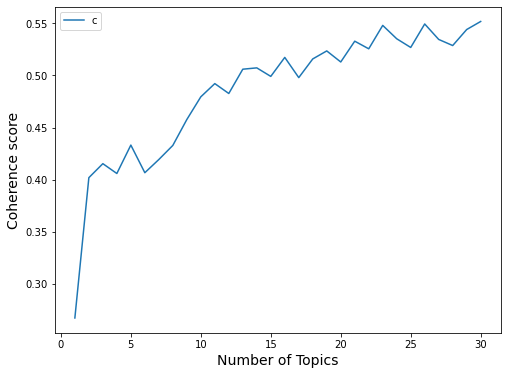

In [10]:
# Show the learning curve of the LdaMulticore model
plt.plot(n_topics, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()

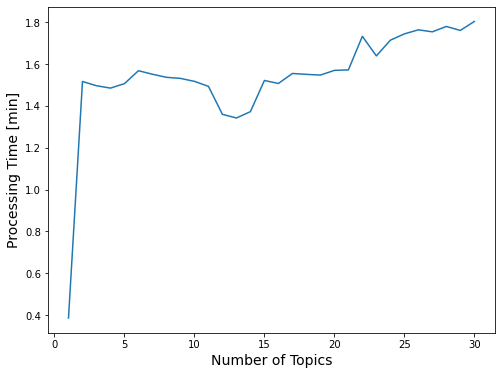

In [11]:
# Show the evolvement of the processing time 
plt.plot(n_topics, processing_times)
plt.xlabel("Number of Topics")
plt.ylabel("Processing Time [min]")
plt.show()

In [12]:
# Take a look at the resulting coherence scores
coherence_values

[0.2670585525402276,
 0.40183422165801785,
 0.41527407972799407,
 0.40584117899905225,
 0.4331251772110499,
 0.4065887665776642,
 0.41926491831927987,
 0.43280553546362077,
 0.4576610788611773,
 0.47948953692457774,
 0.492192776296122,
 0.4826875922662072,
 0.5060158843816092,
 0.5072997862744696,
 0.4991052604117226,
 0.5173469094469374,
 0.49794545167993753,
 0.5158878592592894,
 0.5235737498674055,
 0.5129593007496329,
 0.5329308834560007,
 0.5256104497861481,
 0.5480845236894872,
 0.5352484275327934,
 0.5269049551300093,
 0.5494583888907754,
 0.5346082669354114,
 0.5287475668607107,
 0.5441263232905169,
 0.5518709047804824]

In [13]:
# Take a look at the required processing times (in minutes)
processing_times

[0.3857343792915344,
 1.516830611228943,
 1.4964697043100992,
 1.485192875067393,
 1.5066348473230997,
 1.5684407313664754,
 1.5515002489089966,
 1.5367085933685303,
 1.5316219290097555,
 1.5175063729286193,
 1.4936227917671203,
 1.3596730868021647,
 1.3422743519147238,
 1.372584044933319,
 1.5217037439346313,
 1.5073666373888652,
 1.555142104625702,
 1.5508990367253621,
 1.5475085775057476,
 1.5699177861213685,
 1.5722607096036276,
 1.7329322616259257,
 1.6392253597577413,
 1.7142990152041118,
 1.7444358150164285,
 1.7639297207196554,
 1.7543393929799398,
 1.7800411740938822,
 1.76107257604599,
 1.8039252479871115]

In [14]:
# Take a look at the grid of the number of topics
n_topics

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30]

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 7.2 Summarize and Visualize the Results </h2>
</div>

In [5]:
# Storage of the results for LdaMulticore model with passes = 12
coherence_values = [0.2670585525402276, 0.40183422165801785, 0.41527407972799407, 0.40584117899905225, 0.4331251772110499,
                    0.4065887665776642, 0.41926491831927987, 0.43280553546362077, 0.4576610788611773,  0.47948953692457774,
                    0.492192776296122,  0.4826875922662072,  0.5060158843816092,  0.5072997862744696,  0.4991052604117226,
                    0.5173469094469374, 0.49794545167993753, 0.5158878592592894,  0.5235737498674055,  0.5129593007496329,
                    0.5329308834560007, 0.5256104497861481,  0.5480845236894872,  0.5352484275327934,  0.5269049551300093,
                    0.5494583888907754, 0.5346082669354114,  0.5287475668607107,  0.5441263232905169,  0.5518709047804824]
processing_times = [0.3857343792915344, 1.516830611228943,  1.4964697043100992, 1.485192875067393,  1.5066348473230997,
                    1.5684407313664754, 1.5515002489089966, 1.5367085933685303, 1.5316219290097555, 1.5175063729286193,
                    1.4936227917671203, 1.3596730868021647, 1.3422743519147238, 1.372584044933319,  1.5217037439346313,
                    1.5073666373888652, 1.555142104625702,  1.5508990367253621, 1.5475085775057476, 1.5699177861213685,
                    1.5722607096036276, 1.7329322616259257, 1.6392253597577413, 1.7142990152041118, 1.7444358150164285,
                    1.7639297207196554, 1.7543393929799398, 1.7800411740938822, 1.76107257604599,   1.8039252479871115]
n_topics = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

In [6]:
## Fit a logarithmic model to the resulting coherence scores to get a smooth approximation of the learning curve
# Generate the required logarithmic features on the basis of the n_topics variable
X = np.column_stack((n_topics, np.log(n_topics)))
# Set up and fit the logarithmic regression model
reg = linear_model.LinearRegression(fit_intercept = True)
reg.fit(X, coherence_values)
# Get the fitted values for a homogenous grid of 300 values between the maximum and the minimum n_topics
xnew = np.linspace(np.min(n_topics), np.max(n_topics), 300)
coherence_values_smoothed = reg.predict(np.column_stack((xnew, np.log(xnew))))

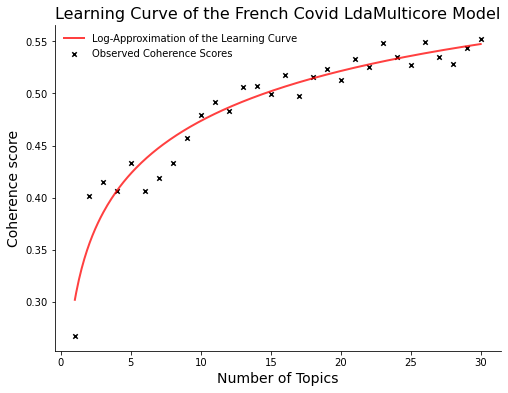

In [7]:
# Show the actual coherence scores obtained together with the smoothly approximated learning curve of the LdaMulticore model
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(n_topics, coherence_values, color = 'black', s = 20, marker = 'x', label = 'Observed Coherence Scores')
#ax.plot(n_topics, coherence_values, color = 'black', linewidth = 1.5, alpha = 0.7, linestyle = '--', label = 'True Learning Curve')
ax.plot(xnew, coherence_values_smoothed, color = 'red', linewidth = 2, alpha = 0.75, label = 'Log-Approximation of the Learning Curve')
ax.set(title = "Learning Curve of the French Covid LdaMulticore Model",
       xlabel = "Number of Topics",
       ylabel = "Coherence score")
ax.legend(loc = 'best', frameon = False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

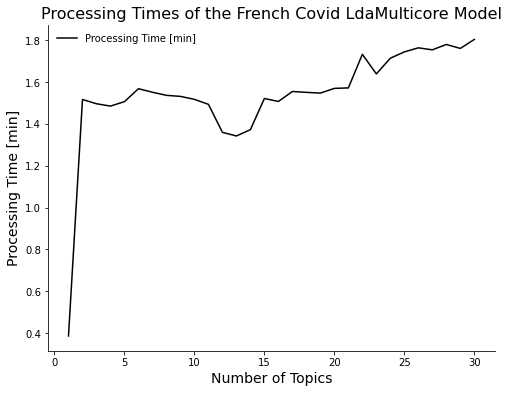

In [8]:
# Show the evolvement of the processing time 
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(n_topics, processing_times, color = 'black', linewidth = 1.5, alpha = 1, linestyle = '-', label = 'Processing Time [min]')
ax.set(title = "Processing Times of the French Covid LdaMulticore Model",
       xlabel = "Number of Topics",
       ylabel = "Processing Time [min]")
ax.legend(loc = 'best', frameon = False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [9]:
# Get the number of topics from the topic model that exhibits the highest coherence score
opt_n_topic = n_topics[np.argmax(np.array(coherence_values))]
# Display the optimal number of topics
print('The optimal number of topics according to the coherence score is', opt_n_topic)

The optimal number of topics according to the coherence score is 30


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 7.3 Determine the optimal K </h2>
</div>

To get a starting point for finding the optimal number of topics $K^*$, we focus on two measures of the estimated models: (1) the coherence score $c(K)$ and (2) the maximal Jaccardian similarity $j(K)$ observed between the top 10 keywords of two of the resulting topics, which is defined by

$$
j(K) = max \left(\frac{|(S_i \cap S_j)|}{|(S_i \cup S_j)|}\right), \ \text{for} \ i \neq j \ \text{and} \ i,j \in \{1,\dots,K\}
$$

where $K$ corresponds to the number of topics in the model and $S_i$ is the set consisting of the top 10 keywords of the $i^{th}$ topic from the model under consideration (note: the maximal Jaccardian similarity measures the highest similarity between two of the resulting topics of a topic model). Our aim is to choose $K$ such that for the corresponding model $c(K)$ is maximized and $j(K)$ is minimized. Since both of these metrics are measured on a scale between 0 and 1, they are directly comparable to each other such that the weighted quality of a model $q_\lambda(K)$ can be measured by the following formula: 

$$
q_\lambda(K) = 2*(\lambda*c(K) - (1-\lambda)*j(K)),
$$

where $\lambda \in [0,1]$ corresponds to the weight assigned to $c(K)$, such that th weight assigned to $j(K)$ is given by $(1-\lambda)$. However, in the present study, we opt for equal weighting of both metrics (i.e. $\lambda = \frac{1}{2}$) to obtain an initial estimate for $K^*$. The topic model relying on the such revealed "optimal" number of topics, $K^*$, is then taken as the first model for the manual review. Then, if the initially selected model appears to deliver too coarse (or too granular) topics, we increase (or decreases) $K$ until a reasonable partitioning is achieved. Furthermore, topic models for which one can reasonably argue that the number of topics is probably too small (e.g. in the context of newspaper articles this would be the case if $K$ is smaller than the number of topics by which most established news outlets sort their articles) are not considered while choosing the opitmal $K$ by means of the approach described above.

In [5]:
# Retrieve the results of the potentially optimal topic models
coherence_values = [0.4331251772110499,
                    0.4065887665776642, 0.41926491831927987, 0.43280553546362077, 0.4576610788611773,  0.47948953692457774,
                    0.492192776296122,  0.4826875922662072,  0.5060158843816092,  0.5072997862744696,  0.4991052604117226,
                    0.5173469094469374, 0.49794545167993753, 0.5158878592592894,  0.5235737498674055,  0.5129593007496329,
                    0.5329308834560007, 0.5256104497861481,  0.5480845236894872,  0.5352484275327934,  0.5269049551300093,
                    0.5494583888907754, 0.5346082669354114,  0.5287475668607107,  0.5441263232905169,  0.5518709047804824]
processing_times = [1.5066348473230997,
                    1.5684407313664754, 1.5515002489089966, 1.5367085933685303, 1.5316219290097555, 1.5175063729286193,
                    1.4936227917671203, 1.3596730868021647, 1.3422743519147238, 1.372584044933319,  1.5217037439346313,
                    1.5073666373888652, 1.555142104625702,  1.5508990367253621, 1.5475085775057476, 1.5699177861213685,
                    1.5722607096036276, 1.7329322616259257, 1.6392253597577413, 1.7142990152041118, 1.7444358150164285,
                    1.7639297207196554, 1.7543393929799398, 1.7800411740938822, 1.76107257604599,   1.8039252479871115]
n_topics = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

In [6]:
# Define the number of top keywords to use while calculating the Jaccardian similarities between topics
num_keywords = 10

# Create a dictionary to store the LDA models
LDA_models = {}

# Create a dictionary to store the top keywords for each topic of the LDA models
LDA_topics = {}

In [7]:
# Load all desired models and extract the corresponding top keywords for their topics
for i in n_topics:
    # Load the model and store it into the LDA_models dictionary
    LDA_models[i] = gensim.models.ldamodel.LdaModel.load("LDA/Covid/fr_lda_model_"+str(i)+"_topics")
    # Extract the num_keywords top keywords for each topic from the model with i topics and store them accordingly in the LDA_topics dictionary
    shown_topics = LDA_models[i].show_topics(num_topics = i, 
                                              num_words = num_keywords,
                                              formatted = False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

In [8]:
# Create a function to calculate the Jaccard similarity of two topics
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = |(A ∩ B)| / |(A ∪ B)|
    - For LDA, the Goal is a low maximal Jaccard score between the topics of a model
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [9]:
## Apply the above defined function to derive the maximal Jaccardian similarity between the top words of the resulting topics for each model
# Create storage to save the maximal topic similarity for each model
max_topic_similarities = []
# Set up a loop to iterate through all models
for model in n_topics:
    # Create storage to save the topic similarities of all possible topic pairs
    topic_similarities = []
    # Get the topics of the current model
    topics = LDA_topics[model]
    # Set up a loop to calculate the topic similarity for all possible topic pairs
    for i in range(model):
        # Set the maximal topic similarity to 0 for the baseline model, which contains only 1 topic
        if model == 1:
            topic_similarities.append(0)
        # Calculate the topic similarity for all possible topic pairs otherwise
        elif i+1 < model:
            for j in range(i+1,model):
                topic_similarities.append(jaccard_similarity(topics[i], topics[j]))
    # Get the maximal topic similarity of the model and store it within the max_topic_similarities variable
    max_topic_similarities.append(np.max(topic_similarities))

# Take a look at the result
#max_topic_similarities

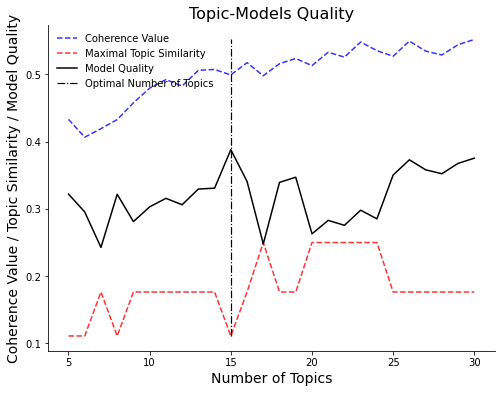

In [15]:
# Calculate the qualities of the models
qualities = np.array(coherence_values) - np.array(max_topic_similarities)

# Calculate the optimal number of topics
opt_n_topic = n_topics[np.argmax(np.array(qualities))]

# Show the development of the coherence scores, the maximal Jaccardian similarities and the model qualities
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(n_topics, coherence_values, color = 'blue', linewidth = 1.5, alpha = 0.8, linestyle = '--', label = 'Coherence Score')
ax.plot(n_topics, max_topic_similarities, color = 'red', linewidth = 1.5, alpha = 0.8, linestyle = '--', label = 'Maximum Topic Similarity')
ax.plot(n_topics, qualities, color = 'black', linewidth = 1.5, alpha = 1, label = 'Model Quality')
ax.plot(np.repeat(opt_n_topic,2), [np.min(max_topic_similarities), np.max(coherence_values)], 
        color = 'black', linewidth = 1.2, alpha = 1, linestyle = '-.', label = 'Optimal Number of Topics')
ax.set(title = "Topic-Models Quality",
       xlabel = "Number of Topics",
       ylabel = "Coherence Score / Topic Similarity / Model Quality")
ax.legend(loc = 'best', frameon = False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [16]:
# Display the optimal number of topics
print('The optimal number of topics is', opt_n_topic)

The optimal number of topics is 15


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 8. Inspect the optimal LDA topic model </h2>
</div>

Since manual inspection of the topic model with 15 topics reveals that this model still yields rather coarse topics, we decide to increase $K$ until the corresponding model exhibits reasonably partitioned topics. For the French articles, this strategy leads us to an optimal choice of $K^* = 19$ for the Covid-19-specific LDA model.

In [5]:
# Load the optimal model from disk and print the topics (adjust the digit appropriately!!!)
opt_n_topic = 19  # adjust the digit accordingly to load the desired model
optimal_model = gensim.models.ldamodel.LdaModel.load("LDA/Covid/fr_lda_model_"+str(opt_n_topic)+"_topics")         
model_topics = optimal_model.show_topics(num_topics = opt_n_topic, num_words = 10, formatted = False)
pprint(optimal_model.print_topics(num_topics = opt_n_topic, num_words = 10))

[(0,
  '0.015*"ville" + 0.011*"habitant" + 0.010*"confinement" + 0.009*"autorité" + '
  '0.009*"mort" + 0.009*"état" + 0.007*"samedi" + 0.007*"feu" + '
  '0.007*"gouvernement" + 0.007*"épidémie"'),
 (1,
  '0.011*"produit" + 0.010*"entreprise" + 0.008*"masque" + 0.008*"production" '
  '+ 0.007*"protection" + 0.007*"marché" + 0.007*"stock" + 0.007*"jeu" + '
  '0.007*"vente" + 0.006*"porte"'),
 (2,
  '0.023*"royaume" + 0.021*"uni" + 0.019*"britannique" + 0.014*"ministre" + '
  '0.012*"confinement" + 0.011*"variant" + 0.011*"gouvernement" + 0.010*"sud" '
  '+ 0.010*"souche" + 0.009*"europe"'),
 (3,
  '0.010*"risque" + 0.010*"falloir" + 0.010*"population" + 0.010*"test" + '
  '0.009*"maladie" + 0.008*"épidémie" + 0.007*"infection" + 0.007*"grippe" + '
  '0.007*"étude" + 0.007*"infecter"'),
 (4,
  '0.097*"masque" + 0.032*"port" + 0.022*"obligatoire" + 0.020*"porter" + '
  '0.013*"distance" + 0.012*"protection" + 0.010*"transport" + '
  '0.009*"respecter" + 0.009*"obligation" + 0.006*"espace"

In [6]:
# Read in the preprocessed data of the Covid articles
articles_topics = pd.read_csv("LDA/Topic_Assignment/topic_assignment_general.csv", index_col = 0)
Covid_idx = articles_topics.loc[np.logical_or(articles_topics['Topic_1'] == 'COVID', 
                                              np.logical_and(articles_topics['Topic_2'] == 'COVID', 
                                                             articles_topics['Affiliation_Prob_2'] >= 0.25))].index
del articles_topics
fr_tx, fr_idx = read_preprocessed('fr')
location = fr_idx[fr_idx.fr_idx.isin(Covid_idx)].index.tolist()
fr_tx = itemgetter(*location)(fr_tx)
fr_idx = fr_idx.iloc[location]
fr_idx.set_index(np.arange(fr_idx.shape[0]), inplace = True)

In [7]:
# Create the corpus again
corpus = [optimal_model.id2word.doc2bow(article) for article in fr_tx]

In [8]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, optimal_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5     -0.184038  0.078934       1        1  9.339919
18     0.112354 -0.074928       2        1  8.749321
3      0.005882 -0.075565       3        1  7.825129
15     0.084437  0.063143       4        1  7.468129
9      0.070713 -0.063669       5        1  7.327636
0     -0.089861  0.085230       6        1  5.912676
10     0.129629  0.016723       7        1  5.694902
16    -0.113086  0.040195       8        1  5.465773
14     0.016727  0.112721       9        1  4.935338
4      0.130249 -0.001668      10        1  4.800132
8     -0.002658 -0.120246      11        1  4.482673
6     -0.183313 -0.232312      12        1  4.440543
11     0.026310 -0.086437      13        1  3.994785
12    -0.063631  0.096657      14        1  3.879896
17     0.008857  0.077695      15        1  3.425845
7      0.063995  0.028803      16        1  3.419673
1      0.105567  0.021139      17        1  3.251827
2     -0.127510  0.063045      18        1  3.145816
13     0.009378 -0.029462      19        1  2.439988, topic_info=         Term          Freq         Total Category  logprob  loglift
94     masque  21513.000000  21513.000000  Default  30.0000  30.0000
779    vaccin   7962.000000   7962.000000  Default  29.0000  29.0000
301   fédéral  17338.000000  17338.000000  Default  28.0000  28.0000
276    canton  20363.000000  20363.000000  Default  27.0000  27.0000
471     chine   9352.000000   9352.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
484     début    510.235386  12510.798749  Topic19  -5.2255   0.5137
13   autorité    514.481000  15753.205340  Topic19  -5.2172   0.2915
276    canton    452.811410  20363.374917  Topic19  -5.3449  -0.0928
150    risque    421.741340  12343.578760  Topic19  -5.4160   0.3367
314     mardi    415.341659   8881.984359  Topic19  -5.4313   0.6505

[1079 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
2348      1  0.561908  19h30
2348      2  0.026837  19h30
2348      3  0.025160  19h30
2348      5  0.043611  19h30
2348      6  0.026837  19h30
...     ...       ...    ...
1982     12  0.001634    île
1982     13  0.001634    île
1982     14  0.055545    île
1982     15  0.267922    île
1982     18  0.004901    île

[10954 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 19, 4, 16, 10, 1, 11, 17, 15, 5, 9, 7, 12, 13, 18, 8, 2, 3, 14])

In [9]:
# Delete unnecessary variables
del fr_tx

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 9. Find the most likely topic for each document </h2>
</div>

In [10]:
# Define a function to retrieve the topic id of the most likely topic assignment for each article together with the according topic affiliation probability
def get_article_topics(ldamodel, corpus, second_most = False):
    # Create storage to save the id of the assigned topics and the according topic affiliation probabilities
    assigned_topics = []
    affiliation_probs = []
    # Keep track of the processing time
    t = time.time()
    # Get the most dominant topic for each document
    for topic_dist_tuples in ldamodel.get_document_topics(corpus):
        # Get a tuple containing the topic id of the second most dominant topic together with the according topic affiliation probability if second_most = True
        if second_most:
            try:
                topic_prob_tuple = sorted(topic_dist_tuples, key = lambda tup: tup[1], reverse = True)[1]
            # If the affiliation probability of the second topic is below 0.01, then the topic is ignored and we therefore returen a tuple of NAs
            except:
                topic_prob_tuple = (np.nan, np.nan)
        # Get a tuple containing the topic id of the most dominant topic together with the according topic affiliation probability otherwise
        else:
            topic_prob_tuple = sorted(topic_dist_tuples, key = lambda tup: tup[1], reverse = True)[0]
        # Extract the topic id of the most dominant topic
        assigned_topics.append(topic_prob_tuple[0])
        # Extract the according topic affiliation probability
        affiliation_probs.append(topic_prob_tuple[1])
    # Print out the processing time
    if second_most:
        print("Processing time to retrieve the second most dominant topic for each article:", str((time.time() - t)/60), "minutes")
    else:
        print("Processing time to retrieve the most dominant topic for each article:", str((time.time() - t)/60), "minutes")
    
    # Return the results
    return assigned_topics, affiliation_probs

In [11]:
# Apply the above defined function to get the most likely topic assignments together with the according topic affiliation probabilities
assigned_topic_1, affiliation_prob_1 = get_article_topics(optimal_model, corpus, second_most = False)

Processing time to retrieve the most dominant topic for each article: 0.2978156805038452 minutes


In [12]:
# Apply the above defined function to get the second most likely topic assignments together with the according topic affiliation probabilities
assigned_topic_2, affiliation_prob_2 = get_article_topics(optimal_model, corpus, second_most = True)

Processing time to retrieve the second most dominant topic for each article: 0.28669050137201946 minutes


In [13]:
# Create a correctly indexed dataframe containing the topic assignment and the according topic affiliation probability
topic_df = pd.DataFrame(assigned_topic_1, index = fr_idx.fr_idx.values.tolist(), columns = ['Topic_ID_1'])
topic_df['Affiliation_Prob_1'] = affiliation_prob_1
topic_df['Topic_ID_2'] = assigned_topic_2
topic_df['Affiliation_Prob_2'] = affiliation_prob_2
# Save the results to a csv file
topic_df.to_csv("LDA/Covid/Topic_Assignment/fr_topic_assignment.csv", index = True)

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 10. Get the most representative articles for each topic (preparation) </h2>
</div>

In [5]:
# Load the optimal model from disk and save the topics' keywords
opt_n_topic = 19  # adjust the digit accordingly to load the desired model
optimal_model = gensim.models.ldamodel.LdaModel.load("LDA/Covid/fr_lda_model_"+str(opt_n_topic)+"_topics")         
model_topics = optimal_model.show_topics(num_topics = opt_n_topic, num_words = 20, formatted = False)

In [6]:
# Read in the Dataframe containing the topic assignments
topic_df = pd.read_csv("LDA/Covid/Topic_Assignment/fr_topic_assignment.csv", index_col = 0, dtype = {'Topic_ID_1': int, 'Affiliation_Prob_1': float, 'Topic_ID_2': float, 'Affiliation_Prob_2': float})

In [7]:
# Read in the preprocessed data of the Covid articles
articles_topics = pd.read_csv("LDA/Topic_Assignment/topic_assignment_general.csv", index_col = 0)
Covid_idx = articles_topics.loc[np.logical_or(articles_topics['Topic_1'] == 'COVID', 
                                              np.logical_and(articles_topics['Topic_2'] == 'COVID', 
                                                             articles_topics['Affiliation_Prob_2'] >= 0.25))].index
del articles_topics
fr_tx_fulltext, fr_idx = read_preprocessed_fulltext('fr')
location = fr_idx[fr_idx.fr_idx.isin(Covid_idx)].index.tolist()
fr_tx_fulltext = itemgetter(*location)(fr_tx_fulltext)
fr_idx = fr_idx.iloc[location]
fr_idx.set_index(np.arange(fr_idx.shape[0]), inplace = True)

In [ ]:
# Define a function to display the most representative articles for each topic
def get_representative_articles(fulltext_data, index_df, topic_assignment_df, topic_id, n_top_articles = 5, show_n_last_elements = None):
    # Define the variable show_n_last_elements appropriatly if it is not defined
    if show_n_last_elements == None:
        show_n_last_elements = n_top_articles
    # Get the index of the most representative articles for the focal topic
    article_ids = topic_assignment_df.loc[topic_assignment_df['Topic_ID_1'] == topic_id].sort_values(by = ['Affiliation_Prob_1'], ascending = False)[:n_top_articles].index
    # Get the location of theses articles in the list of fulltexts
    location = []
    for article_id in article_ids:
        location.append(index_df.loc[index_df.iloc[:,0] == article_id].index[0])
    # Print out the identified articles
    return list(fulltext_data[i] for i in location)[(n_top_articles-show_n_last_elements):]

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 10.1 Display most representative articles for each topic </h2>
</div>

In [ ]:
## Topic 0
# Define the id of the topic of interest
id_focal_topic = 0
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(0,
 [('ville', 0.01458903),
  ('habitant', 0.011216667),
  ('confinement', 0.009681617),
  ('autorité', 0.009413717),
  ('mort', 0.009216605),
  ('état', 0.009208156),
  ('samedi', 0.00734311),
  ('feu', 0.007198579),
  ('gouvernement', 0.006960372),
  ('épidémie', 0.0069300393),
  ('capitale', 0.0068874126),
  ('région', 0.006855277),
  ('an', 0.006775792),
  ('million', 0.006456105),
  ('dimanche', 0.0059074713),
  ('heure', 0.00541187),
  ('ministre', 0.005242323),
  ('nord', 0.005214513),
  ('début', 0.005192282),
  ('sud', 0.0051522604)])


[" Les inondations et glissements de terrain provoqués par la mousson ont fait plusieurs morts au Bangladesh, au Népal et en Inde. ATS/NXPLa menace d’une montée des eaux des fleuves plane sur les prochains jours en Asie du Sud. Près de 200 personnes ont péri dans les inondations et glissements de terrain provoqués par la mousson au Bangladesh, au Népal et en Inde, ont annoncé dimanche les autorités de ces pays d'Asie du Sud. Ils ont mis en garde contre la montée des eaux des fleuves dans les prochains jours. Au Bangladesh, au moins 67 personnes ont péri et 2,6 millions ont été affectées au cours des deux dernières semaines par les inondations causées par les cours d'eau en crue, ont indiqué les autorités. Sur le total, 55 personnes sont mortes noyées et huit foudroyées lors des intempéries, a déclaré à l'AFP la porte parole du ministère de la Santé, Ayesha Akther. La situation pour ce qui concerne les inondations s'est améliorée au cours des derniers jours. Mais le niveau des eaux des 

In [ ]:
# Further highly ranked articles of topic 0
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 15, show_n_last_elements = 3)

[' Au moins 52 détenus ont été tués, hier, lors d’une mutinerie dans une prison d’Altamira, dans l’Etat brésilien du Para (nord). Seize prisonniers ont été décapités. C’est un affrontement entre membres de factions rivales. Deux gardiens avaient été pris en otages, mais ils ont déjà été libérés, a expliqué une porte parole du système pénitentiaire du Para. Avec près de 727 000 détenus recensés en 2016, le Brésil compte la troisième population pénitentiaire au monde. La capacité des prisons est deux fois moindre, environ 368 000 places, dans ce pays de près de 210 millions d’habitants. ATS',
 ' BOSNIE De fortes pluies ont causé des inondations, notamment dans le nord du pays. Plusieurs villes ont déclaré hier l’état d’urgence et ordonné l’évacuation de la population. Un garçon de 6 ans a été emporté par un ruisseau en crue. Des équipes de sauvetage sont à sa recherche. Les habitants redoutent le scénario de mai 2014. Des inondations avaient alors affecté près de 2 millions de personnes 

In [ ]:
## Topic 1
# Define the id of the topic of interest
id_focal_topic = 1
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 10)

(1,
 [('produit', 0.011298375),
  ('entreprise', 0.010320921),
  ('masque', 0.008363536),
  ('production', 0.007518546),
  ('protection', 0.00744721),
  ('marché', 0.0071667586),
  ('stock', 0.007014778),
  ('jeu', 0.0068474505),
  ('vente', 0.0065512215),
  ('porte', 0.0062526255),
  ('client', 0.006022966),
  ('grand', 0.005146948),
  ('prix', 0.005013371),
  ('matériel', 0.005006089),
  ('pharmacie', 0.0049393796),
  ('demande', 0.004923691),
  ('vendre', 0.0048376285),
  ('mars', 0.004735072),
  ('million', 0.0046669315),
  ('parole', 0.0046473616)])


['magasins Vögele Shoes va fermer une soixantaine de boutiques en Suisse, pour faire face à l’effondrement des recettes provoqué par la pandémie et la concurrence féroce du commerce en ligne, a indiqué au site Blick. ch le patron de l’enseigne, Max Bertschinger. Le réseau du vendeur de chaussures, en mains du polonais CCC depuis 2018, doit passer à environ 100 bonnes boutiques, contre actuellement environ 160 magasins, a dit Max Bertschinger. Entre début avril et fin juin, les recettes de l’enseigne ont été divisées par deux, à 17 millions de francs. ats',
 'chine En Chine, la course à la fabrication de masques en pleine pandémie de Covid 19 a fait s’en voler le prix des matières premières et pénalise le secteur des produits d’hygiène, notamment... des couches pour bébé. Le pays s’est lancé dans un effort de guerre pour produire suffisamment de masques pour le personnel médical et protéger son 1,4 milliard d’ha bitants. Mais ce marché est devenu très lucratif et le prix des matériaux f

In [ ]:
# Further highly ranked articles of topic 1
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 20, show_n_last_elements = 2)

[' CoronavirusObtenir une ligne de production chinoise pour produire des masques est une galère. Par Pierre André SieberLes masques de protection sont en rupture de stock et la date de disponibilité n’est pas connue. Mis à rude épreuve par le coronavirus, les gros fabricants de masques (lire ci dessous) font difficilement face à la demande et composent avec les réquisitions des gouvernements. En Suisse, la riposte s’organise. Orchestrée par la Confédération, avec l’aide de Swissmem, faîtière de l’industrie des machines, l’opération visant à doter la Suisse d’une capacité de production de masques prend du temps, car les chaînes automatisées ne sont plus produites dans le pays, mais en Chine. Le fournisseur de ces engins miracles déniché par Swissmem est Autefa Solutions à Frauenfeld (TG), succursale d’une société internationale spécialiste des équipements pour l’industrie. Ce fleuron fait partie du groupe China Hi Tech Cooperation (CHTC) depuis 2011. Nous sommes en train de résoudre tou

In [ ]:
## Topic 2
# Define the id of the topic of interest
id_focal_topic = 2
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(2,
 [('royaume', 0.02307539),
  ('uni', 0.021121118),
  ('britannique', 0.019439794),
  ('ministre', 0.013638216),
  ('confinement', 0.011856137),
  ('variant', 0.011431999),
  ('gouvernement', 0.010631824),
  ('sud', 0.009798054),
  ('souche', 0.009505736),
  ('europe', 0.009344023),
  ('décembre', 0.009107785),
  ('noël', 0.008232234),
  ('johnson', 0.0079633035),
  ('afrique', 0.00793358),
  ('variante', 0.00769809),
  ('boris', 0.007449151),
  ('mort', 0.0074103107),
  ('européen', 0.0072508925),
  ('angleterre', 0.0071168705),
  ('vague', 0.0064027114)])


[" Plus de trois millions d’habitants de la province britannique devront rester à la maison dès vendredi 18h. En Belgique, cafés et restaurants ferment pour un mois. ATS/NXPA partir de vendredi, il sera demandé aux plus de trois millions d'habitants du Pays de Galles de rester à la maison (archives). Le Pays de Galles a annoncé lundi l’instauration à partir de vendredi d’un confinement de deux semaines pour tenter de freiner la deuxième vague de l’épidémie de nouveau coronavirus. Il introduit ainsi les restrictions les plus dures au Royaume Uni. A partir de 18h00 vendredi, il sera demandé aux plus de trois millions d’habitants de la province britannique de rester à la maison, a expliqué le Premier ministre gallois Mark Drakeford lors d’une conférence de presse. La durée de ce pare feu est la plus courte qui puisse être introduite pour être efficace, a t il ajouté. Les commerces non essentiels devront fermer, conduisant à une situation comparable au confinement instauré au Royaume Uni à

In [ ]:
# Further highly ranked articles of topic 2
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 10, show_n_last_elements = 2)

[' La France vient à son tour de détecter la présence de Covid 19 dans un élevage de visons en Eure et Loir (sud ouest de Paris). Les mille bêtes à fourrure ont été abattues, a fait savoir dimanche le Ministère de l’agriculture. Plusieurs pays européens ont déjà rapporté des contaminations d’élevages de visons, principalement le Danemark, avec la découverte récente d’un virus variant, mais aussi les Pays Bas puis la Suède, la Grèce, et des cas isolés en Italie et en Espagne. ATS',
 ' Couvre feu en Belgique et en Slovénie, nouveau tour de vis en Italie: les restrictions se durcissent en Europe pour tenter de freiner une deuxième vague de la pandémie de Covid 19. Le virus a déjà fait 250 000 morts sur le continent. L’annonce la plus forte est venue du Pays de Galles, qui sera soumis, à partir de vendredi, à un confinement de deux semaines. ATs']

In [ ]:
## Topic 3
# Define the id of the topic of interest
id_focal_topic = 3
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(3,
 [('risque', 0.009895377),
  ('falloir', 0.009866806),
  ('population', 0.009580697),
  ('test', 0.009500848),
  ('maladie', 0.009015626),
  ('épidémie', 0.0076954514),
  ('infection', 0.007042025),
  ('grippe', 0.0070177657),
  ('étude', 0.006796492),
  ('infecter', 0.0065734116),
  ('symptôme', 0.006524009),
  ('scientifique', 0.005582589),
  ('transmission', 0.0050345017),
  ('faire', 0.0048392373),
  ('contact', 0.0046811914),
  ('temps', 0.0044423016),
  ('mois', 0.004358381),
  ('enfant', 0.0042565046),
  ('grand', 0.0041477173),
  ('vague', 0.004133421)])


[" Une étude réalisée en France montre que les rhumes ou les bronchites saisonniers ne protègent pas les enfants du virus, ni des formes graves apparentées à la maladie de Kawasaki. AFP/NXPLes enfants font des formes de Covid 19 peu symptomatiques qui passent souvent inaperçues. Les fréquentes infections par des coronavirus saisonniers, responsables chaque hiver de rhumes et de bronchites dès la petite enfance, ne protègent ni de l’infection par le nouveau coronavirus, ni des formes graves liées au Covid 19 apparentées à la maladie de Kawasaki, selon une étude. L’étude, coordonnée par l’hôpital Necker (AP HP, Paris) et l'Institut Pasteur et mise en ligne sur le site de pré publication Medrxiv, confirme la grande fréquence et le taux important d’anticorps contre les coronavirus saisonniers dans la population générale, ce qui n’empêche pourtant pas les infections par ces virus chaque hiver. L’infection par les coronavirus saisonniers n’offre pas une protection significative contre l’infe

In [ ]:
## Topic 4
# Define the id of the topic of interest
id_focal_topic = 4
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(4,
 [('masque', 0.097021334),
  ('port', 0.032254886),
  ('obligatoire', 0.021908624),
  ('porter', 0.020345723),
  ('distance', 0.013090199),
  ('protection', 0.011674388),
  ('transport', 0.010377504),
  ('respecter', 0.009142332),
  ('obligation', 0.008672624),
  ('espace', 0.006217892),
  ('lieu', 0.0061567603),
  ('règle', 0.0059308163),
  ('mètre', 0.005408033),
  ('faire', 0.0052735847),
  ('imposer', 0.005253493),
  ('social', 0.004662702),
  ('main', 0.004455626),
  ('client', 0.004344444),
  ('protéger', 0.0043050423),
  ('heure', 0.0042789206)])


[' Des gadgets fonctionnels simplifient la routine quotidienne du port du masque: des imprimés variés apportent de la couleur, des boîtes de rangement assurent une bonne hygiène et des porte masques aident à avoir ces protections toujours sous la main. Porte masque Très pratique lorsque le masque doit être mis et retiré fréquemment. Différents coloris,1 pièce Fr. 2. 90Community Mask Masque en coton lavable,3 couches, avec élastique réglable pour les oreilles. Différents coloris,1 pièce Fr. 6. 90Community Mask Masque en coton lavable, 3 couches, avec élastique réglable pour les oreilles. Différents coloris,1 pièce Fr. 6. 90Community Mask Kids Masque en tissu lavable, taille S, spécialement conçu pour les enfants et les ados. Différents motifs. 1 pièce Fr. 8. 90Masques d’hygiène de type IIR, noirs. 50 pièces Fr. 14. 90Mask Keeper Étuis pliables pour masques d’hygiène. 3 pièces, assortis Fr. 3. 30Étui à masques 1 pièce Fr. 3. 90Community Mask Masque en coton lavable, 3 couches, avec élast

In [ ]:
# Further highly ranked articles of topic 4
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 12, show_n_last_elements = 3)

[' Le Conseil national a accepté hier que les personnes qui ne portent pas de masque et ne respectent pas les plans de protection soient punies. Mais l’amende pourrait ne pas être infligée lorsque l’obligation de porter un masque n’est pas clairement établie. Le montant maximal de la contravention pour la personne ne portant pas de masque serait de 300 fr. ',
 ' MASQUES Colorés, ornés de motifs et en vente partout: les dispositifs de protection en tissu ont la cote. Utilisés correctement, ils protègent surtout les autres. Et si chacun protège autrui, nous serons tous protégés, note Christian Chuard, de l’Hôpital fribourgeois (HFR). Pour être efficace, un masque en tissu doit avoir plusieurs couches, mais le spécialiste en infectiologie ne s’étend pas sur la nécessité d’un filtre. En revanche, il insiste sur un autre point: Il faut avoir avec cet objet la même hygiène qu’avec sa brosse à dents ou ses sous vêtements. Donc ne pas le laisser traîner, ni le frotter partout, et le laver dès 

In [ ]:
## Topic 5
# Define the id of the topic of interest
id_focal_topic = 5
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(5,
 [('mort', 0.02709167),
  ('décès', 0.020036878),
  ('million', 0.014447999),
  ('unis', 0.013383251),
  ('monde', 0.012924658),
  ('etat', 0.012762947),
  ('contamination', 0.012621271),
  ('état', 0.010138621),
  ('bilan', 0.010089805),
  ('épidémie', 0.00975734),
  ('enregistrer', 0.0090837795),
  ('heure', 0.008439926),
  ('début', 0.007918333),
  ('total', 0.0075120875),
  ('mercredi', 0.007200559),
  ('recenser', 0.007169631),
  ('lundi', 0.0071650157),
  ('toucher', 0.0071289083),
  ('jeudi', 0.007024851),
  ('vendredi', 0.006759021)])


[' Selon un comptage réalisé par l’AFP, au moins 25 millions de personnes ont été contaminées par le coronavirus dans le monde. Le Brésil et les États Unis sont les deux pays les plus touchés. AFP/NXPAvec plus de 120’000 décès, le Brésil est le deuxième pays le plus endeuillé par la pandémie derrière les États Unis. Un hommage aux victimes avait été rendu le 8 août sur la plage de Copacabana à Rio de Janeiro. Plus de 25 millions de cas du nouveau coronavirus ont été officiellement recensés dans le monde, dont plus de la moitié en Amérique, selon un comptage réalisé par l’AFP à partir de sources officielles dimanche à 05h20, heure suisse. Au total, au moins 25’029’50 cas, dont 842’915 décès, ont été déclarés. Près de 4 cas sur 10 se situent aux États Unis et au Brésil, les deux pays les plus touchés avec respectivement 5’960’652 cas (182’760 décès) et 3’846’153 cas (120’262 décès). Le rythme de la pandémie semble se stabiliser dans le monde, avec un million de cas supplémentaires détect

In [ ]:
# Further highly ranked articles of topic 5
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 20, show_n_last_elements = 2)

[' L’Europe, avec au moins 205’065 morts, reste le continent le plus touché, alors que plus de 100’000 nouveaux morts ont été enregistrés en 21 jours. AFP/NXPLes États Unis sont le pays ayant enregistré le plus de morts au total (140’103), devant le Brésil. La pandémie du coronavirus a tué plus de 600’000 personnes dans le monde depuis sa découverte en Chine en décembre, dont plus de 200’000 en Europe et 160’000 en Amérique latine, selon un bilan réalisé par l’AFP à partir de sources officielles dimanche à 03H00. Au total, 600’523 décès ont été recensés dans le monde (pour 14’233’355 cas), dont 205’065 morts en Europe, région la plus touchée. La pandémie progresse rapidement en Amérique latine, deuxième continent avec le plus de décès recensés (160’726 dont 17’540 ces sept derniers jours). Plus de 140’000 morts aux États UnisLes États Unis sont le pays ayant enregistré le plus de morts au total (140’103) devant le Brésil (78’772), le Royaume Uni (45’273), le Mexique (38’888) et l’Itali

In [ ]:
## Topic 6
# Define the id of the topic of interest
id_focal_topic = 6
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(6,
 [('ofsp', 0.03196481),
  ('canton', 0.024938786),
  ('test', 0.024505032),
  ('quarantaine', 0.020438883),
  ('office', 0.019331602),
  ('dernier', 0.019207612),
  ('décès', 0.018745355),
  ('infection', 0.017929452),
  ('fédéral', 0.017419485),
  ('total', 0.016041873),
  ('heure', 0.014342365),
  ('chiffre', 0.013522034),
  ('positif', 0.012098604),
  ('ats', 0.0120860925),
  ('confirmer', 0.011678468),
  ('taux', 0.011385164),
  ('contamination', 0.010819907),
  ('supplémentaire', 0.010074068),
  ('début', 0.010065178),
  ('habitant', 0.009696437)])


[" Ces dernières 24 heures, 268 personnes ont été diagnostiquées positives au Covid 19, selon le bilan de l’OFSP. Un décès de plus a été enregistré. ats/nxpLa Suisse et le Liechtenstein comptaient vendredi 268 cas supplémentaires de coronavirus en 24 heures (archives). La Suisse et le Liechtenstein comptaient vendredi 268 cas supplémentaires de coronavirus en 24 heures, selon les chiffres de l'Office fédéral de la santé publique (OFSP). Un décès de plus est enregistré, portant le total à 1716. Les chiffres de vendredi marquent une hausse par rapport à ceux de la veille (234 cas). Le nombre de cas n’est plus repassé sous la barre des 100 depuis le 3 août. Et il faut remonter à mi avril pour trouver des chiffres aussi élevés. Sur les sept derniers jours, le nombre total d’infections est de 1317, indique le bulletin d’information quotidien de l’OFSP. Depuis le début de la pandémie, 37’671 cas de contamination au Covid 19 ont été confirmés en laboratoire sur un total de 868’886 tests effec

In [ ]:
## Topic 7
# Define the id of the topic of interest
id_focal_topic = 7
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(7,
 [('raison', 0.016019262),
  ('lieu', 0.015913973),
  ('manifestation', 0.015513592),
  ('organisateur', 0.015345755),
  ('prévoir', 0.0150952),
  ('annuler', 0.014034464),
  ('événement', 0.012859791),
  ('année', 0.011874566),
  ('grand', 0.011019123),
  ('ats', 0.009638862),
  ('fête', 0.008627769),
  ('reporter', 0.008471065),
  ('participant', 0.007879808),
  ('prochain', 0.007822809),
  ('organiser', 0.007780027),
  ('mars', 0.007750028),
  ('décision', 0.007465949),
  ('rassemblement', 0.0072549293),
  ('monde', 0.0067386976),
  ('édition', 0.006666302)])


[" Après le Paléo, les organisateurs du Montreux Jazz Festival jettent à leur tour l'éponge en raison de la pandémie. Le Montreux Jazz Festival (MJF) qui devait se dérouler du 3 au 18 juillet est à son tour annulé en raison de la pandémie de Covid 19. La programmation prévue cet été sera en partie reportée à la prochaine édition qui se tiendra du 2 au 17 juillet 2021. C'est avec un profond regret que l'organisation du MJF a annoncé sa décision vendredi matin. En 53 ans d'histoire, d'aventures humaines et de moments musicaux légendaires, jamais une édition du festival n'avait dû être annulée, relève t elle dans un communiqué. Le Conseil fédéral a annoncé jeudi assouplir progressivement certaines mesures de protection contre le coronavirus, mais maintient la majorité des mesures d'hygiène et de distanciation sociale nécessaires, explique t elle. Dès lors, il est aujourd'hui impossible d'envisager une manifestation de l'ampleur du MJF au mois de juillet, à l'instar des autres festivals d'

In [ ]:
# Further highly ranked articles of topic 7
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 20, show_n_last_elements = 2)

[' CoronavirusLa sentence est tombée hier: les organisateurs des Courses de Bienne, dont la 62e édition aurait dû se tenir du 4 au 6 juin 2020, ont décidé d’annuler la manifestation de cette année en raison de la pandémie de coronavirus. La protection de la santé de toutes les personnes concernées est au centre de cette décision, indiquent ils sur leur site internet. Nous devons à toutes les personnes impliquées de prendre dès maintenant une décision claire et de communiquer rapidement, précise le président de la manifestation Martin Reber. Les coureurs inscrits seront informés dès que possible des modalités concernant les frais d’inscription. La prochaine édition des Courses de Bienne, avec leur épreuve phare des 100 Km, aura lieu du 10 au 12 juin 2021. Autre course de la région prévue le 2 mai, les 11 km de Nidau sont aussi annulés. ck',
 ' Le calendrier du championnat du monde de Formule 1 devrait compter cette année de 15 à 18 courses malgré les reports et annulations entraînés par

In [ ]:
## Topic 8
# Define the id of the topic of interest
id_focal_topic = 8
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 3)

(8,
 [('hôpital', 0.040805545),
  ('patient', 0.028424695),
  ('soin', 0.027817104),
  ('intensif', 0.019233389),
  ('lit', 0.012630926),
  ('situation', 0.011568226),
  ('vague', 0.011383005),
  ('personnel', 0.009591833),
  ('malade', 0.0095024565),
  ('médecin', 0.008698665),
  ('hug', 0.00840073),
  ('canton', 0.007861145),
  ('hospitalisation', 0.0075399037),
  ('atteindre', 0.0075317025),
  ('service', 0.007465278),
  ('hospitaliser', 0.007015363),
  ('hospitalier', 0.006761992),
  ('décès', 0.0065400754),
  ('soignant', 0.006526478),
  ('valais', 0.0064377543)])


[' Covid 19 Face à la hausse des hospitalisations, des mesures sont adoptées pour augmenter le nombre de patients pouvant être accueillis en soins intensifs. Par Sevan Pearson L e Réseau hospitalier neuchâtelois (RHNE) est confronté à une situation sanitaire qui devient critique. C’est ce cri d’alarme qu’a lancé, hier, l’établissement dans un communiqué de presse. Lundi, il évoquait déjà un nombre d’hospitalisations liées au Covid 19 dépassant le pic du printemps. Rien qu’entre mardi soir et hier matin, le RHNE a hospitalisé douze patients, portant le total à 89. Avec 16 cas suspects dans l’attente du résultat du test, l’hôpital cantonal a dépassé le cap symbolique des 100 lits occupés par des cas Covid depuis le début de la deuxième vague de l’épidémie. Cela représente bientôt 50 du dispositif initial en lits de soins aigus du réseau, indique le communiqué. Préoccupant, critique Aux Hôpitaux universitaires de Genève, on qualifie la situation de préoccupante. Hier, à midi, 20 des perso

In [ ]:
## Topic 9
# Define the id of the topic of interest
id_focal_topic = 9
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 2)

(9,
 [('fédéral', 0.039082456),
  ('conseil', 0.030074583),
  ('canton', 0.027681664),
  ('situation', 0.014246751),
  ('alain', 0.011632347),
  ('berset', 0.011238984),
  ('confédération', 0.010567102),
  ('conseiller', 0.009004387),
  ('falloir', 0.008372272),
  ('président', 0.007110312),
  ('berne', 0.0063468968),
  ('ministre', 0.006183305),
  ('romand', 0.0061254106),
  ('faire', 0.005647625),
  ('décision', 0.0055752),
  ('population', 0.0053604133),
  ('cantonal', 0.0050313496),
  ('gouvernement', 0.005016665),
  ('état', 0.0046293805),
  ('vague', 0.0045269965)])


[' Les cantons romands redoutent que le Conseil fédéral ne prenne des mesures valables pour tout le pays alors qu’ils ont fait beaucoup d’efforts pour freiner la propagation du virus. Les éventuelles nouvelles mesures contre le Covid 19 présentées mardi par Simonetta Sommaruga et Alain Berset ont provoqué de vives réactions en Suisse romande. L’ensemble des gouvernements cantonaux de ce côté de la Sarine préparent une réponse commune. ATS/NXPLes cantons romands redoutent que le Conseil fédéral ne prenne des mesures valables pour tout le pays alors qu’ils ont fait beaucoup d’efforts pour freiner la propagation du virus. Le Gouvernement jurassien n’a pas caché mercredi son irritation après l’annonce par le Conseil fédéral d’éventuelles nouvelles mesures contre le Covid 19. Un sentiment partagé par l’ensemble des gouvernements cantonaux romands qui préparent une réponse commune, a annoncé le ministre jurassien Jacques Gerber. Les annonces du Conseil fédéral hier à 18h30 ont surpris et ont

In [ ]:
# Further highly ranked articles of topic 9
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 18, show_n_last_elements = 3)

[' SUISSE Les directeurs cantonaux de la Santé voudraient aller plus loin que les décisions annoncées vendredi dernier. Ils demandent des mesures rapides et décisives. Mais, selon plusieurs journaux de Tamedia, Berne n’envisagerait pas de durcir les règles avant le 28 décembre. Plusieurs scénarios seront évalués en fonction du taux de reproduction du virus et de la charge sur les hôpitaux. Le confinement fait partie des mesures envisagées en tout dernier recours. ',
 ' VIRUS Nous avons été beaucoup trop optimistes en été, après la première vague de coronavirus, quand on a pensé que nous pourrions rouvrir les grandes manifestations à l’automne, a déclaré le ministre de la Santé Alain Berset à la TV alémanique SRF. Mais le pire est de rester bloqué et de ne rien faire, selon lui. Si l’on fait des erreurs, une chose est claire, il faut les corriger aussi vite que possible. ATS',
 ' L’épidémiologiste Marcel Tanner, du groupe de travail Covid 19 du Conseil fédéral, met en garde contre une p

In [ ]:
## Topic 10
# Define the id of the topic of interest
id_focal_topic = 10
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 3)

(10,
 [('restaurant', 0.02300812),
  ('fermer', 0.020864679),
  ('fermeture', 0.013727972),
  ('bar', 0.013534111),
  ('établissement', 0.012345803),
  ('canton', 0.011252705),
  ('heure', 0.009897759),
  ('commerce', 0.009094238),
  ('conseil', 0.008778684),
  ('décembre', 0.00845051),
  ('client', 0.008305691),
  ('rouvrir', 0.007347715),
  ('lieu', 0.007211192),
  ('salle', 0.006802802),
  ('magasin', 0.006187712),
  ('activité', 0.005845023),
  ('état', 0.0057649408),
  ('autoriser', 0.005749653),
  ('cinéma', 0.0055846726),
  ('réouverture', 0.005476024)])


[" Le Conseil fédéral a annoncé mercredi de nouvelles décisions pour lutter contre une résurgence de la pandémie de coronavirus en Suisse, notamment la fin des exceptions cantonales dès samedi. La prolongation des mesures en vigueur jusqu'à fin février et un durcissement des mesures ont par ailleurs été mis en consultation auprès des cantons. RESTAURANTS Les établissements de restauration doivent rester fermés. Seuls les plats à emporter, les cantines scolaires et d'entreprise et les restaurants d'hôtel pour les clients de l'hôtel sont autorisés à ouvrir. Les services de livraison restent également autorisés. Dès samedi, cette mesure sera appliquée à tous les cantons. Le Conseil fédéral a supprimé l'exception dont pouvaient se prévaloir les cantons où la situation était plus favorable. LIEUX CULTURELS Tous les lieux culturels, les centres de loisirs et les installations sportives resteront fermés. Cette mesure concerne les musées, les cinémas, les bibliothèques, les casinos, les jardin

In [ ]:
# Further highly ranked articles of topic 10
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 15, show_n_last_elements = 3)

[' Coronavirus Le Conseil fédéral a pris hier des mesures supplémentaires dans la lutte contre le coronavirus. Les restaurants, mais aussi les établissements sportifs, culturels ou de loisirs, devront fermer leurs portes dès mardi. Les capacités des magasins seront limitées. Tout comme pour la première série de mesures décidées vendredi passé, les cantons les moins touchés pourront décider d’assouplissements, comme l’ouverture des restaurants ou des centres sportifs. Quant à l’ouverture des domaines skiables, elle est conditionnée à l’autorisation des cantons. 2/3Les restaurants doivent fermer dès mardi, sauf dans les cantons les moins touchés par la pandémie. Keystone',
 '11 MAI GastroSuisse a édicté hier une série de règles pour les cafés, bars et restaurants qui veulent rouvrir lundi. L’une d’elles exige notamment d’enregistrer l’identité de tous les clients à des fins de traçabilité du virusTrop de contraintes, trop d’incertitudes et beaucoup de craintes poussent de nombreux restau

In [ ]:
## Topic 11
# Define the id of the topic of interest
id_focal_topic = 11
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(11,
 [('positif', 0.026856238),
  ('école', 0.026320416),
  ('quarantaine', 0.02111165),
  ('tester', 0.019600607),
  ('élève', 0.016942611),
  ('joueur', 0.0143978745),
  ('match', 0.013413358),
  ('club', 0.012150757),
  ('équipe', 0.012051186),
  ('test', 0.011907913),
  ('classe', 0.010091962),
  ('enseignant', 0.008123854),
  ('enseignement', 0.0073830755),
  ('enfant', 0.007334222),
  ('cours', 0.006732621),
  ('scolaire', 0.0060882564),
  ('football', 0.005960899),
  ('vendredi', 0.0057922667),
  ('contact', 0.0057399897),
  ('médecin', 0.0057071447)])


[' Les joueurs zurichois Mirlind Kryeziu (FCZ) et Amel Rustemoski (GC) ont été testés positifs au Covid 19 vendredi. Équipes en quarantaine et matches reportés. SportcenterLe premier cas officiel sérieux de coronavirus chez un joueur de Super League est tombé du côté du FC Zurich ce vendredi après midi: il s’agit du défenseur Mirlind KryeziuAprès l’alerte Boris Babic, annoncé positif par Saint Gall mais qui n’avait jamais été en contact avec ses coéquipiers, le premier cas officiel sérieux de coronavirus chez un joueur de Super League est tombé du côté du FC Zurich ce vendredi après midi: il s’agit du défenseur Mirlind Kryeziu. Depuis l’apparition des premiers symptômes, décrits comme mineurs par le club entraîné par le Vaudois Ludovic Magnin, le défenseur de 23 ans a été mis en quarantaine et n’a pas participé à la préparation de la réception du FC Sion au programme de samedi. Samedi dernier, Mirlind Kryeziu était entré en jeu dix minutes lors de la victoire des siens face au Servette

In [ ]:
# Further highly ranked articles of topic 11
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 14, show_n_last_elements = 2)

[' Le club valaisan compte 13 joueurs contaminés ainsi que 9 membres de son encadrement, y compris Fabio Grosso. Son match contre Lucerne est d’ores et déjà reporté. Nicolas JacquierEn quarantaine depuis le 21 octobre dernier, le FC Sion ne pourra pas sortir de son isolement. Initialement, le club de Tourbillon aurait pu reprendre l’entraînement ce week end déjà mais il n’en a pas obtenu l’autorisation des autorités sanitaires du canton. Les résultats des tests auxquels se sont soumis vendredi passé aussi bien les joueurs que les membres du staff valaisan sont tombés ce lundi matin. Ils sont sans équivoque: sur les 18 joueurs qui figuraient sur la feuille de match du derby contre Lausanne (0 0 le 18 octobre), pas moins de treize sont aujourd’hui positifs. Une dizaine de membres de l’encadrement technique, dont l’entraîneur Fabio Grosso, ainsi que de la cellule médicale sont également touchés. On ne vit que d’emmerdes. Dans ces conditions, quel est le sens de vouloir essayer de continue

In [ ]:
## Topic 12
# Define the id of the topic of interest
id_focal_topic = 12
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(12,
 [('italie', 0.025536893),
  ('frontière', 0.022032145),
  ('italien', 0.017777208),
  ('vol', 0.011953687),
  ('france', 0.01104331),
  ('quarantaine', 0.010711987),
  ('région', 0.009518257),
  ('passager', 0.00933194),
  ('gouvernement', 0.008476318),
  ('voyageur', 0.008236946),
  ('européen', 0.0076209875),
  ('provenance', 0.007420076),
  ('fermer', 0.0073359814),
  ('aérien', 0.007007064),
  ('contrôle', 0.0069120736),
  ('dimanche', 0.0065606902),
  ('aéroport', 0.006516705),
  ('compagnie', 0.006137677),
  ('voyage', 0.006056104),
  ('frontalier', 0.0059682275)])


[' Europe La Commission européenne a appelé hier les Etats membres de l’UE et de l’espace Schengen (dont la Suisse) à prolonger d’un mois l’interdiction temporaire sur les voyages non essentiels vers l’UE, jusqu’au 15 juin. Malgré des premiers assouplissements des mesures de lutte contre la pandémie de nouveau coronavirus au sein du bloc, la situation reste fragile à la fois en Europe et dans le monde, estime l’Exécutif européen. C’est la deuxième fois que la Commission invite les Etats membres à prolonger l’interdiction des voyages depuis sa mise en place le 17 mars. Cette fermeture des frontières extérieures de l’UE et de l’espace Schengen compte un certain nombre d’exceptions (ressortissants européens et leur famille, résidents de longue date, diplomates, personnel soignant, chercheurs, transfrontaliers…). Elle concerne 30 pays au total, en comptant la Suisse, la Norvège, l’Islande et le Liechtenstein. Nous devrons progressivement mettre fin aux restrictions de la libre circulation 

In [ ]:
# Further highly ranked articles of topic 12
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 20, show_n_last_elements = 5)

[' Transports Le gouvernement italien est indigné par les obstructions des camions au Brenner. Parce que l’Autriche a introduit des contrôles frontaliers stricts en raison de la propagation du coronavirus, les camions sont temporairement bloqués jusqu’à 90 kilomètres. ATS',
 ' Transports Le gouvernement italien est indigné par les obstructions des camions au Brenner. Parce que l’Autriche a introduit des contrôles frontaliers stricts en raison de la propagation du virus coronavirus, les camions sont temporairement bloqués jusqu’à 90 kilomètres. ATS',
 ' Cinq pays européens (France, Espagne, Allemagne, Italie et Pays Bas) réfléchissent à la mise en place de corridors sanitaires pour faciliter les déplacements à l’intérieur de l’UE malgré la pandémie de Covid 19. ATS',
 ' Les trains régionaux Tilo, reliant la Suisse et l’Italie, ont repris hier leur service sans restrictions entre le Tessin et la Lombardie. La décision de débloquer la situation a été prise par les gouvernements des deux p

In [ ]:
## Topic 13
# Define the id of the topic of interest
id_focal_topic = 13
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 2)

(13,
 [('vaccin', 0.06503208),
  ('vaccination', 0.042708345),
  ('vacciner', 0.027547965),
  ('dose', 0.024430456),
  ('campagne', 0.018845819),
  ('million', 0.015762202),
  ('janvier', 0.014582518),
  ('pfizer', 0.0124108875),
  ('biontech', 0.009919376),
  ('an', 0.009497233),
  ('recevoir', 0.008832907),
  ('décembre', 0.008758568),
  ('population', 0.008375554),
  ('commencer', 0.0075739003),
  ('déjà', 0.0074891113),
  ('fin', 0.0073441938),
  ('année', 0.0070356466),
  ('mois', 0.006857152),
  ('premier', 0.006594729),
  ('ici', 0.0063454835)])


[' Coronavirus La plus grande campagne de vaccination de l’histoire suisse a débuté. La toute première personne être vaccinée en Suisse contre le Covid 19 est une femme âgée de 90 ans. C’était dans un EMS lucernois. Des seniors ont aussi été vaccinés dans quatre autres cantons alémaniques. Comme ailleurs en Suisse, la vaccination contre le Covid 19 respecte, en terres lucernoises, une liste de priorités. La population dans son ensemble ne devrait y avoir accès qu’à partir de la fin du printemps 2021. D’ici au début de l’automne prochain, tous les Lucernois qui le souhaitent devraient avoir pu être vaccinés. Les 107 000 premières doses du vaccin de Pfizer/Biontech ont été livrées, mardi, à la Suisse, puis redistribuées par l’armée aux cantons. Pour garantir une protection efficace, le vaccin du consortium américano allemand doit être injecté une seconde fois trois semaines après la première injection. Vaccinations ailleursComme Lucerne, le canton de Zoug a, lui aussi, effectué hier ses 

In [ ]:
# Further highly ranked articles of topic 13
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 20, show_n_last_elements = 4)

[" En première suisse, une femme âgée de 90 ans a été vaccinée mercredi matin dans un home lucernois pour personnes âgées. C’est une nonagénaire qui été la première Suissesse vaccinée du Covid 19. Elle lance la plus grande action de vaccination contre le virus dans notre pays. ATS/NXPEn première suisse, une femme âgée de 90 ans a été vaccinée mercredi matin dans un home lucernois pour personnes âgées. La plus grande action de vaccination de l’Histoire suisse a commencé. La première personne a été vaccinée mercredi matin contre le coronavirus dans le canton de Lucerne. Il s’agit d’une femme âgée de 90 ans. Le ministre lucernois de la santé Guido Graf a confirmé aux médias l’information lors d’une visite d’un centre de vaccination contre le coronavirus. Les 107’000 premières doses du vaccin de Pfizer/Biontech ont été livrées mardi à la Suisse, puis redistribuées par l'armée aux cantons. Comme le canton de Lucerne, Appenzell Rhodes Intérieures a aussi annoncé que le petit canton de Suisse

In [ ]:
## Topic 14
# Define the id of the topic of interest
id_focal_topic = 14
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(14,
 [('président', 0.022724088),
  ('ministre', 0.014306413),
  ('gouvernement', 0.01344336),
  ('trump', 0.012326294),
  ('français', 0.0118742185),
  ('france', 0.010845629),
  ('état', 0.010272946),
  ('etat', 0.010117124),
  ('donald', 0.009558006),
  ('confinement', 0.008952366),
  ('américain', 0.008855399),
  ('mai', 0.0073648044),
  ('crise', 0.0073215114),
  ('déconfinement', 0.0070135426),
  ('macron', 0.006929658),
  ('chef', 0.006380784),
  ('emmanuel', 0.0060592666),
  ('épidémie', 0.0057773404),
  ('politique', 0.0056495205),
  ('faire', 0.00543157)])


[" Alors que le Covid 19 continue de faire près de 1000 victimes par jour aux Etats Unis, le président US a crié victoire en conférence de presse vendredi. Nous avons pris toutes les décisions qu'il fallait, affirme Donald Trump. AFPDonald Trump a affirmé vendredi que les Etats Unis avaient largement surmonté la pandémie de Covid 19, qui continue de faire autour d'un millier de morts chaque jour dans le pays. La force de l’économie USCommentant la baisse surprise du chômage en mai, le président des Etats Unis a vanté la force de l'économie américaine. Cette force nous a permis de surmonter cette horrible pandémie, nous l'avons largement surmontée, a t il dit lors d'une conférence de presse à la Maison Blanche. Nous avons pris toutes les décisions qu'il fallait, a t il encore assuré, alors que sa gestion de la crise sanitaire a été souvent critiquée. Selon le milliardaire républicain, les Etats Unis ont fait un grand pas dans leur rebond, et les prochains mois démontreront que l'économi

In [ ]:
# Further highly ranked articles of topic 14
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 14, show_n_last_elements = 5)

[' En tête dans les sondages, Joe Biden a voté hier dans son fief de Wilmington. Il a dénoncé comme une insulte à ceux qui souffrent la gestion de la pandémie de Covid 19 par son rival Donald Trump. ATS',
 ' Le candidat à la Maison Blanche Joe Biden n’ira pas en personne accepter sa nomination à la convention démocrate de Mil\xadwaukee, dans le Wisconsin. Il entend ainsi protéger la santé publique en pleine pandémie de Covid 19. ATS',
 ' CORONAVIRUS Ils et elles sont coiffeur, bistrotière ou patronne d’une entreprise de déménagement, et la pandémie les a mis au repos forcéLorsque le confinement a été décrété, nous étions allés recueillir leurs craintesAujourd’hui, l’heure est à la reprise. Comment négocient ils cette lente renaissance? Nous sommes retournés les voirPAGES 12 13',
 ' Les Français forcés pour la première fois de travailler de chez eux pendant le confinement ont été plus sujets aux lombalgies, selon une enquête de Santé publique France, qui suggère des mesures d’améliorati

In [ ]:
## Topic 15
# Define the id of the topic of interest
id_focal_topic = 15
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(15,
 [('crise', 0.017218295),
  ('aide', 0.011406944),
  ('économie', 0.009853113),
  ('économique', 0.009550969),
  ('confinement', 0.008672039),
  ('entreprise', 0.008602111),
  ('million', 0.008220279),
  ('mois', 0.007904645),
  ('milliard', 0.007864464),
  ('année', 0.0070119216),
  ('franc', 0.006704525),
  ('faire', 0.005669789),
  ('social', 0.0056333346),
  ('travail', 0.005150953),
  ('secteur', 0.0051314807),
  ('monde', 0.005085303),
  ('situation', 0.005021968),
  ('déjà', 0.0047320216),
  ('chômage', 0.0046724216),
  ('face', 0.004584143)])


[' Giancarlo Mariani, rédacteur en chefLes ravages de la crise du coronavirus sont désastreux et lourds de conséquences pour une grande partie de la population. Et en particulier les plus précaires d’entre nous, ceux qui n’ont pas de sécurité ou dont le statut passe au travers des mailles du filet social. Pour bien prendre conscience de la gravité de la situation à Genève, il suffit de remonter les interminables files d’attente qui se forment dans les rues à l’heure de la distribution de l’aide d’urgence. Ces colonnes de démunis, longues comme un jour sans pain, font froid dans le dos. Même l’association d’aide les Colis du Cœur tire la sonnette d’alarme. Selon ses chiffres, les bénéficiaires de bons alimentaires ont triplé en quelques semaines. D’ici à mai, ils seront près de 9000 à s’en sortir grâce à son dispositif. Du jamais vu. Ce qui choque aussi dans cette véritable explosion sociale, c’est que beaucoup de ces laissés pour compte n’étaient pas jusqu’à présent dans les radars. Po

In [ ]:
# Further highly ranked articles of topic 15
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 10, show_n_last_elements = 5)

[" Une action internationale coordonnée, qui a fait la preuve de son efficacité lors de la crise financière de 2008, est incontournable pour endiguer l'impact économique de l'épidémie du coronavirus, a souligné hier le FMI. Mais, pour l'heure, les pays réagissent en ordre dispersé. Les coûts humains du coronavirus se sont accrus à un rythme alarmant et l'impact économique est déjà visible dans les pays les plus touchés, a déploré Gita Gopinath, économiste en chef du Fonds monétaire international dans un blog publié lundi. Soulignant que l'enjeu est d'empêcher qu'une crise temporaire ne nuise de façon irrémédiable à des personnes et des entreprises en raison de pertes d'emplois et de faillites, elle a appelé les gouvernements à prendre des mesures ciblées importantes d'ordre budgétaire, monétaire et financier, citant entre autres allègements d'impôts et aides financières directes. ",
 ' Après un premier appel aux dons lancé en mars pour aider les personnes, en Suisse, dont la situation 

In [ ]:
## Topic 16
# Define the id of the topic of interest
id_focal_topic = 16
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 3)

(16,
 [('chine', 0.033004306),
  ('épidémie', 0.024207903),
  ('oms', 0.02137383),
  ('chinois', 0.018973438),
  ('wuhan', 0.016153462),
  ('mondial', 0.012669704),
  ('autorité', 0.010568031),
  ('organisation', 0.009866019),
  ('pékin', 0.008299775),
  ('maladie', 0.008098828),
  ('mort', 0.008052233),
  ('ville', 0.007394882),
  ('monde', 0.0070248144),
  ('an', 0.0068149376),
  ('international', 0.006007807),
  ('janvier', 0.0056626303),
  ('million', 0.0055437125),
  ('urgence', 0.0053461203),
  ('province', 0.005322012),
  ('centre', 0.0052420897)])


[" La Chine, touchée par une mystérieuse pneumonie, a recensé mardi 77 nouveaux cas. Un premier cas suspect est aussi apparu en Australie. Alors que de nombreux autres pays d'Asie renforcent leurs contrôles face à la propagation du virus qui a déjà fait quatre morts. Un total de 291 cas ont été confirmés et 922 patients sont en observation, a annoncé dans un communiqué la Commission nationale de la Santé chinoise. Un cas suspect a été décelé en Australie. Un homme rentrant de Chine et présentant les symptômes d'un mystérieux virus, proche du Sras et transmissible entre humains, a été placé à l'isolement à son domicile, ont annoncé mardi les autorités sanitaires australiennes. Il s'agit du premier cas suspect dans le pays de ce nouveau coronavirus. Un porte parole des autorités sanitaires du Queensland a indiqué que cet homme est récemment rentré de Wuhan, une ville de centre de la Chine où la grande majorité des contaminations ont été recensées. La responsable de la santé publique dans

In [ ]:
# Further highly ranked articles of topic 16
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 10, show_n_last_elements = 2)

[" Infecté par le mystérieux virus qui touche déjà plus de 200 personnes, un Chinois est mort dimanche à Wuhan. La Chine a annoncé mardi un quatrième mort victime d'un mystérieux virus semblable au Sras et transmissible entre humains, alors que l'Organisation mondiale de la santé (OMS) s'apprêtait à tenir une réunion d'urgence. Les autorités sanitaires ont indiqué qu'un homme de 89 ans avait succombé à des difficultés respiratoires à Wuhan (centre), ville de 11 millions d'habitants où la grande majorité des contaminations ont jusqu'à présent été recensées. Dans toute la Chine, il y en a eu plus de 200. Le virus, de la famille du Sras (syndrome respiratoire aigu sévère), touche désormais plusieurs grandes villes du pays dont Pékin et Shanghai et trois autres pays d'Asie: Japon, Corée du Sud et Thaïlande. Un animal à la sourceZhong Nanshan, un scientifique chinois renommé de la Commission nationale de la santé, a déclaré lundi soir à la télévision publique CCTV que la transmission par co

In [ ]:
## Topic 17
# Define the id of the topic of interest
id_focal_topic = 17
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(17,
 [('région', 0.016650664),
  ('station', 0.013191506),
  ('allemagne', 0.012922862),
  ('touriste', 0.010942933),
  ('allemand', 0.010776731),
  ('espagne', 0.00885705),
  ('ski', 0.00862943),
  ('tourisme', 0.0077280765),
  ('vacance', 0.0074421237),
  ('hôtel', 0.007296915),
  ('zone', 0.007106906),
  ('étranger', 0.006999588),
  ('risque', 0.0068198275),
  ('quarantaine', 0.006612184),
  ('venir', 0.006476973),
  ('merkel', 0.0059952443),
  ('touristique', 0.0056216745),
  ('gouvernement', 0.005324702),
  ('angela', 0.005009675),
  ('berlin', 0.0049055014)])


[' Coronavirus Les restrictions aux frontières avec la France, l’Allemagne et l’Autriche doivent être levées ces prochaines semaines si la situation sanitaire le permet. Cette liberté retrouvée concernera aussi bien les voyages d’affaires que les loisirs: Il y a un accord sur le fait que le retour à la normalité doit intervenir aussi vite que possible, a confirmé Philipp Schwander, porte parole du Département fédéral de justice et police (DFJP), au Blick. Des vacances d’été en Allemagne, en Autriche et en France seraient alors possibles. Réd. ',
 ' Coronavirus Les restrictions aux frontières avec la France, l’Allemagne et l’Autriche doivent être levées ces prochaines semaines si la situation sanitaire le permet. Cette liberté retrouvée concernera aussi bien les voyages d’affaires que les loisirs: Il y a un accord sur le fait que le retour à la normalité doit intervenir aussi vite que possible, a confirmé Philipp Schwander, porte parole du Département fédéral de justice et police (DFJP)

In [ ]:
# Further highly ranked articles of topic 17
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 9, show_n_last_elements = 4)

[' Le rebond des infections limite la liberté de circulation dans le pays. Indésirables, les Berlinois se retrouvent coincés dans la capitale. Christophe BourdoiseauBerlinOn avait conseillé aux Allemands de privilégier l’Allemagne pour leurs vacances d’automne. Maintenant, on leur demande carrément de rester chez eux! Avec le rebond des infections, qui ont doublé en une semaine (près de 4000 ces trois derniers jours), c’est la panique! Nous risquons de perdre le contrôle, a prévenu Lothar Wieler, le patron de l’Institut de veille sanitaire Robert Koch. Ne gâchons pas tous nos efforts en relâchant notre vigilance, a insisté Angela Merkel. La chancelière a annoncé vendredi le renfort de l’armée (Bundeswehr) avec l’envoi d’experts pour lutter contre le Covid 19. À la veille des vacances d’automne, l’Allemagne est comme une fourmilière dans laquelle on aurait mis un grand coup de pied. Plus personne ne sait où se déplacer sans risquer une amende ou, pire, être mis en quarantaine loin de ch

In [ ]:
## Topic 18
# Define the id of the topic of interest
id_focal_topic = 18
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(18,
 [('cantonal', 0.0102657415),
  ('canton', 0.008612682),
  ('faire', 0.007376867),
  ('médecin', 0.007322276),
  ('situation', 0.006923268),
  ('em', 0.0068315123),
  ('service', 0.0068039787),
  ('personnel', 0.0064950576),
  ('contact', 0.006037502),
  ('risque', 0.005822994),
  ('quarantaine', 0.0058098594),
  ('respecter', 0.0057565924),
  ('social', 0.005465877),
  ('résident', 0.0053168926),
  ('famille', 0.005229054),
  ('état', 0.005137482),
  ('heure', 0.005050477),
  ('genève', 0.004976759),
  ('distance', 0.0048701037),
  ('enfant', 0.00485805)])


[' Le coronavirus met les établissements pénitentiaires sous tension. Dans le canton de Vaud, une pétition a été adressée au directeur de la prison pour femmes de la Tuilières. Une dizaine de détenues s\'y plaignent des mesures prises pour lutter contre l’épidémie. Datée du 18 mars, la missive pointe du doigts la suppression des visites au parloir. Les détenues craignent pour la qualité de leurs relations sociales, surtout pour celles qui ont des enfants. L’isolement est d’autant plus dur à encaisser en milieu carcéral. ""Bien évidemment qu\'une période telle que celle que nous traversons exacerbe les tensions, aussi bien dans la société qu\'en prison"", admet Sylvie Bula, la cheffe du service pénitentiaire du canton de Vaud. ""Les personnes détenues ont peur pour elles mêmes, ont peur pour leurs proches qui sont à l\'extérieur. "" Les mesures qui ont été rajoutées suscitent ""pas mal de questions et de réactions, qui ont pu être vives dans certains endroits"", ajoute t elle. Protéger 

In [ ]:
# Further highly ranked articles of topic 18
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 10, show_n_last_elements = 5)

[' La police cantonale fribourgeoise a tiré un bilan positif de ce troisième week end des vacances de Pâques. Présentes dans le terrain et notamment sur les hotspot du canton, les patrouilles de police ont constaté que, de manière générale, la population a bien respecté les directives émises par l’OFSP. Les policiers rappellent que les consignes reste d’actualité. Du côté vaudois, on affiche moins le sourire, même avec un bon respect des restrictions en général, les policiers ont constaté que le sentiment d’impatience de la population se faisait ressentir sur différents aspects liés à l’environnement. ',
 " Dès le début de la crise, Pascal Lazzaretti a voulu profiter de son confinement pour mettre son temps à disposition. Son idée: offrir une oreille attentive aux populations âgées et isolées. D'autres témoignages suivront. Frédéric Thomasset|Lorraine Fasler|Jean Daniel SallinÀ l'heure où le Covid 19 frappe le monde, la Suisse et le canton, les autorités ont demandé aux Genevois de lim

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 11. Topic Distribution </h2>
</div>

In [ ]:
# Get the topics and the according counts
topics, counts = np.unique(topic_df.Topic_ID_1, return_counts = True)
print(topics)
print(counts)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
[1732  830  667 1590 1054 1843 1520 1797  852 1693 1624 1812  868  522
 1054 1997 1442  706 2400]


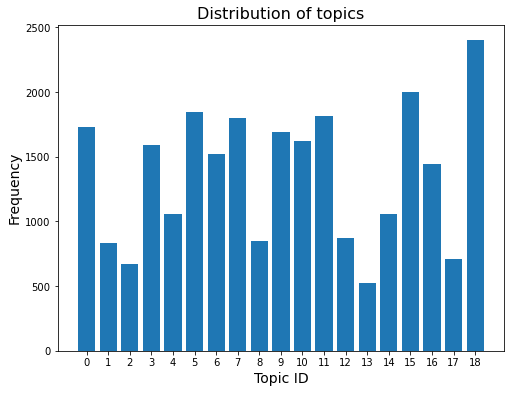

In [ ]:
# Plot the topic distribution
plt.title("Distribution of topics")
plt.xlabel("Topic ID")
plt.ylabel("Frequency")
plt.bar(topics, counts, align = 'center')
plt.gca().set_xticks(topics)
plt.show()